# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Conteúdo</p></div>     
   
- Libraries
- Configurations
- Loading Data
- **Data Preparation** 
    - Encoding
    - Normalization
    - Standardzation
    - Feature Selection
- **Model** 
    - Train-Test Split
    - Cross Validation
    - Models
        - LightGBM Classifier
        - XGboost Classifier
        - Artifical Neural Network
- **Hypertuning**
    - Optuna
        - LightGBM Classifier
        - XGboost Classifier
        - Artifical Neural Network
     - Save Best Models
- **Feture Importance**
    - Enssemble Method
        - LightGBM Classifier Feature Importance
        - XGboost Classifier Feature Importance
    - Filter Method
        - Anova
        - Pearson Correlation
    - Wrapper Methods
        - Shapley

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Libraries</p></div>

In [1]:
# !pip install -U scikit-learn
# !pip install lightgbm
# !pip install optuna
# !pip install category-encoders
# !pip install -q -U torch watermark
# !pip install -q -U scikit-learn watermark
# !pip install graphviz
# !pip install shap

In [2]:
%run part01_preprocessing.ipynb

Last updated: 2023-04-24T10:14:19.539300-03:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.19.0-40-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

/home/alysson/projects/Hotel-Booking-Cancelations/data/data_processed/hotel_bookings_processed.csv
/home/alysson/projects/Hotel-Booking-Cancelations/data/data_raw/hotel_bookings.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              11

In [356]:
# Basic Tools
import pandas as pd
import numpy as np
from datetime import datetime as dt

# Visualization Tools
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# File / OS tools
import json
from watermark import watermark
import os


# Machine Learning Models
import xgboost
from xgboost import XGBClassifier, plot_importance
import lightgbm
from lightgbm import LGBMClassifier, plot_importance 

# Deep Learning Models
import torch
from torch import nn, optim
import torch.nn.functional as F

# Preprocessing Tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder
from category_encoders.count import CountEncoder

# Model Selection Tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
import optuna

# Model Evaluation Tools
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, classification_report

# Feature Importance Tools
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, VarianceThreshold, SelectPercentile
import shap
from shap import plots

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Configurations</p></div>

In [4]:
#Global Seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,scikit-learn,optuna,lightgbm,torch,shap,category_encoders
#watermark --iversion

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

numpy            : 1.23.4
pandas           : 1.5.1
scikit-learn     : 0.0.post1
optuna           : 3.1.1
lightgbm         : 3.3.5
torch            : 2.0.0
shap             : 0.41.0
category_encoders: 2.6.0



# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Preparation</p></div> 

In [306]:
data_prep = data.copy()
data_prep.tail(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,people,kids,days_stay,country_name,continentes
119231,City Hotel,0,34,2017,August,35,31,2,5,2,0,0,BB,DEU,Online TA,TA/TO,0,...,D,0,No Deposit,9,0,0,Transient,157.7100,0,4,Check-Out,2017-09-07,2,0,7,Germany,Europe
119232,City Hotel,0,109,2017,August,35,31,2,5,2,0,0,BB,GBR,Online TA,TA/TO,0,...,A,0,No Deposit,89,0,0,Transient,104.4000,0,0,Check-Out,2017-09-07,2,0,7,United Kingdom,Europe
119233,City Hotel,0,205,2017,August,35,29,2,7,2,0,0,HB,DEU,Online TA,TA/TO,0,...,A,0,No Deposit,9,0,0,Transient,151.2000,0,2,Check-Out,2017-09-07,2,0,9,Germany,Europe


In [307]:
rh = data.loc[(data["hotel"] == "Resort Hotel")].copy()
ch = data.loc[(data["hotel"] == "City Hotel")].copy()

In [308]:
data_prep.isna().sum().sum()

0

In [309]:
data_prep=data_prep.dropna()

### <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Encoding</p></div>

In [310]:
#data_prep["foreigner"] = [0 if i =='PRT' else 1 for i in data_prep["country"]] # 0=native or 1=foreigner

#data_prep["company"] = [0 if i == 0 else 1 for i in data_prep["company"]]

hotel_dict = {'City Hotel': 0,  'Resort Hotel':1}
data_prep['hotel'] = data_prep['hotel'].map(hotel_dict) 

meal_dict = {'SC': 0,  'HB': 1, 'BB': 2, 'FB':3}
data_prep['meal'] = data_prep['meal'].map(meal_dict)

continentes_dict = {'Unknow':-1,'Native': 0,'Europe': 1, 'Asia': 2, 'North America':3, 'South America':4, 'Oceania':5, 'Africa':6 }
data_prep['continentes'] = data_prep['continentes'].map(continentes_dict) 

market_segment_dict = {'Undefined':-1,'Online TA': 0,'Offline TA/TO': 1, 'Groups': 2, 'Corporate':3, 'Direct':4, 'Aviation':5, 'Complementary':6}
data_prep['market_segment'] = data_prep['market_segment'].map(market_segment_dict)

distribution_dict = {'Undefined':-1,'TA/TO': 0,'Direct': 1, 'Corporate': 2, 'GDS':3}
data_prep['distribution_channel'] = data_prep['distribution_channel'].map(distribution_dict) 


customer_type_dict = {'Transient': 0,'Transient-Party': 1, 'Contract': 2, 'Contract':3, 'Group':4}
data_prep['customer_type'] = data_prep['customer_type'].map(customer_type_dict) 

n = 20
top_agents = data_prep['agent'].value_counts().nlargest(n).index
top_companies = data_prep['company'].value_counts().nlargest(n).index
data_prep['agent'] = np.where(data_prep['agent'].isin(top_agents), data_prep['agent'], -1)
data_prep['company'] = np.where(data_prep['company'].isin(top_companies), data_prep['company'], -1)

# count = CountEncoder(cols=data_prep[['country']], return_df=True) 
# data_prep= count.fit_transform(data_prep)

In [311]:
data_prep.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [312]:
data.distribution_channel.value_counts(), data.market_segment.value_counts()

(TA/TO        97766
 Direct       14612
 Corporate     6658
 GDS            193
 Undefined        5
 Name: distribution_channel, dtype: int64,
 Online TA        56412
 Offline TA/TO    24191
 Groups           19793
 Direct           12582
 Corporate         5283
 Complementary      736
 Aviation           235
 Undefined            2
 Name: market_segment, dtype: int64)

In [195]:
#data_prep = pd.get_dummies(data_prep, columns = ['market_segment','customer_type'])

In [114]:
# le = LabelEncoder()
# data_prep['hotel'] = le.fit_transform(data_prep['hotel'])

# # Aplicar OrdinalEncoder na coluna "meal"
# oe = OrdinalEncoder(categories=[['SC', 'HB', 'BB', 'FB']])
# data_prep['meal'] = oe.fit_transform(data_prep[['meal']])

# # Filtering only top 10 most used agency and companies
# n = 11
# top_agents = data_prep['agent'].value_counts().nlargest(n).index
# top_companies = data_prep['company'].value_counts().nlargest(n).index
# data_prep['agentd'] = np.where(data_prep['agent'].isin(top_agents), data_prep['agent'], -1)
# data_prep['company'] = np.where(data_prep['company'].isin(top_companies), data_prep['company'], -1)

# # Aplicar OneHotEncoder nas colunas "market_segment" e "customer_type"
# ohe = OneHotEncoder()
# ohe_data = ohe.fit_transform(data_prep[['market_segment', 'customer_type','continentes']])
# ohe_cols = [f'{col}_{cat}' for col, cats in zip(['market_segment', 'customer_type','continentes'], ohe.categories_) for cat in cats]
# xxx = pd.concat([data_prep, pd.DataFrame(ohe_data.toarray(), columns=ohe_cols)], axis=1)

In [115]:
# pipeline = make_pipeline(
#     LabelEncoder(),
#     OrdinalEncoder(categories=[['SC', 'HB', 'BB', 'FB']]),
#     OneHotEncoder(),
#     #FunctionTransformer(lambda x: x['country'].map(x['country'].value_counts(normalize=True))),
#     FunctionTransformer(lambda x: np.where(x.isin(x.value_counts().nlargest(10).index), x, -1)),
#     LGBMClassifier()
# )

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Feature Selection</p></div>

In [318]:
selected_features = ['hotel',
                     #'is_canceled',
                     'lead_time',
                     'arrival_date_year',   
                     #'arrival_date_month',
                     'arrival_date_week_number',
                     #'arrival_date_day_of_month',
                     #'stays_in_weekend_nights',                    
                     #'stays_in_week_nights',
                     #'adults',
                     #'children',
                     #'babies',
                     'meal',
                     #'country',
                     'market_segment',
                     'distribution_channel',
                     'is_repeated_guest',
                     'previous_cancellations',
                     #'assigned_room_type',
                     #'previous_bookings_not_canceled',
                     #'reserved_room_type',
                     'booking_changes',
                     #'deposit_type',
                     'agent',
                     'company',
                     #'days_in_waiting_list',
                     'customer_type',
                     'adr',
                     'required_car_parking_spaces',
                     'total_of_special_requests',
                     #'reservation_status_date',
                     'people',
                     'continentes',
                     #'kids',
                     'days_stay',
                     #'foreigner'
                    ]

In [314]:
target = 'is_canceled'

In [236]:
drop_features = ['hotel',
                 #'is_canceled',
                 #'lead_time',
                 #'arrival_date_year',   
                 'arrival_date_month',
                 #'arrival_date_week_number',
                 'arrival_date_day_of_month',
                 'stays_in_weekend_nights',                    
                 'stays_in_week_nights',
                 'adults',
                 'children',
                 'babies',
                 #'meal',
                 'country',
                 #'market_segment',
                 'distribution_channel',
                 #'is_repeated_guest',
                 #'previous_cancellations',
                 'assigned_room_type',   
                 'previous_bookings_not_canceled',
                 'reserved_room_type',
                 'booking_changes',
                 'deposit_type',
                 #'agent',
                 #'company',
                 'days_in_waiting_list',
                 #'customer_type',
                 #'adr',
                 #'required_car_parking_spaces',
                 #'total_of_special_requests',
                 'reservation_status_date',
                 'reservation_status',
                 #'people',
                 'country',
                 #'continentes',
                 'country_name',
                 'kids',
                 #'days_stay',
                 #'foreigner'
                    ]

In [237]:
#data_prep=data_prep.drop(drop_features, axis=1)

In [319]:
data_prep[selected_features]

,hotel,lead_time,arrival_date_year,arrival_date_week_number,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,booking_changes,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,people,continentes,days_stay
0,1,342,2015,27,2,4,1,0,0,3,0,0,0,0.0000,0,0,2,0,0
1,1,737,2015,27,2,4,1,0,0,4,0,0,0,0.0000,0,0,2,0,0
2,1,7,2015,27,2,4,1,0,0,0,0,0,0,75.0000,0,0,1,1,1
3,1,13,2015,27,2,3,2,0,0,0,-1,0,0,75.0000,0,0,1,1,1
4,1,14,2015,27,2,0,0,0,0,0,240,0,0,98.0000,0,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119229,0,23,2017,35,2,1,0,0,0,0,-1,0,0,96.1400,0,0,2,1,7
119230,0,102,2017,35,2,0,0,0,0,0,9,0,0,225.4300,0,2,3,1,7
119231,0,34,2017,35,2,0,0,0,0,0,9,0,0,157.7100,0,4,2,1,7
119232,0,109,2017,35,2,0,0,0,0,0,-1,0,0,104.4000,0,0,2,1,7


## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Normalization</p></div>

In [365]:
log_columns = data_prep[selected_features].skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]
print('Columns/Skew\n',log_columns)    

Columns/Skew
 previous_cancellations        24.4456
adr                           10.6003
people                        10.3122
company                        7.9637
booking_changes                5.5007
is_repeated_guest              5.3645
required_car_parking_spaces    4.1628
days_stay                      3.1902
customer_type                  2.7317
continentes                    2.3891
distribution_channel           2.2844
agent                          1.6880
total_of_special_requests      1.3493
lead_time                      1.3458
market_segment                 1.1154
dtype: float64


In [146]:
def applylog(log_columns):
    for col in log_columns.index:
        data_prep[col] = np.log1p(data_prep[col])

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Standardization</p></div>

In [147]:
# #mms = MinMaxScaler()
# rbs = RobustScaler()
# for col in data_prep[selected_features]:
#     #data_prep[col] = mms.fit_transform(data_prep[[col]]).squeeze()
#     data_prep[col] = rbs.fit_transform(data_prep[[col]]).squeeze()    

In [149]:
#data_prep[selected_features]

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Model</p></div> 

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Train-Test Split</p></div>

In [320]:
y = data_prep[target]
#X = data_prep.drop('is_canceled',axis=1)
X = data_prep[selected_features]

In [321]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((95387, 19), (95387,), (23847, 19), (23847,))

In [248]:
# pipeline.fit(X_train, y_train)

# # Avaliar o modelo
# from sklearn.metrics import accuracy_score
# y_pred = pipeline.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Acurácia do modelo: {accuracy:.3f}')

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Cross Validation</p></div>

In [322]:
def CM(y, y_pred):
    labels = ["Não Cancelado", "Cancelado"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")  
    plt.show()
    print("Score: \n", classification_report(y,y_pred)) 


def ROC(model, y, y_prob, model_dict):
    score_metrics_auc = pd.DataFrame(columns=['Model','AUC'])
    
    #y_prob = model.fit(X,y)
    #y_prob = model.predict_proba(X)
    #y_prob = y_prob[:,1]   
    
    
    fpr,tpr, threshold = roc_curve(y,y_prob)
    auc = roc_auc_score(y,y_prob)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr,tpr, color='steelblue', label = model_dict)    
    plt.title("ROC")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.xlabel("False Positives Rate (1- Specifity)")
    plt.ylabel("True Positives Rate (Sensitivity)")
    plt.legend(loc = 'lower right') 
    plt.show()
    print(f"AUC: {auc:.4f}\n\n") 
    
    #score_metrics_auc.loc[i]=[pipe_dict[i], auc]   
   
    return y_prob, auc

In [323]:
def CVS(model, X, y, model_dict=''):    
    
    scoring = {'Accuracy': make_scorer(accuracy_score),
               'Precision': make_scorer(precision_score),
               'Recall': make_scorer(recall_score),
               'F1': make_scorer(f1_score),
               'AUC': make_scorer(roc_auc_score)}   
    
    number_folds = 5
    #Kfold = KFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED)    
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    
    y_prob = cross_val_predict(model, X, y, cv=Kfold, method='predict_proba', verbose=False)    
    y_prob = y_prob[:,1]
    
    ### Defining threshold ###
    y_pred = np.empty(shape=(len(y_prob)))
    threshold = 0.5
    for i in range(len(y_prob)):    
        if y_prob[i] >= threshold:
            y_pred[i] = 1  
        else:
            y_pred[i] = 0  
   
    CM(y,y_pred)
    ROC(model, y, y_prob, model_dict) 
  
    scores = cross_validate(model, X, y, cv = Kfold, scoring=scoring, return_train_score=True)
    
    df = pd.DataFrame.from_dict(scores).T
    df['mean_folds5'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    #display(df[['mean_folds5','std']])
    display(df)
    return y_prob, y_pred, scores

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM</p></div>

In [324]:
#lr = LogisticRegression(random_state=RANDOM_SEED)
lgbm = LGBMClassifier(random_state=RANDOM_SEED)

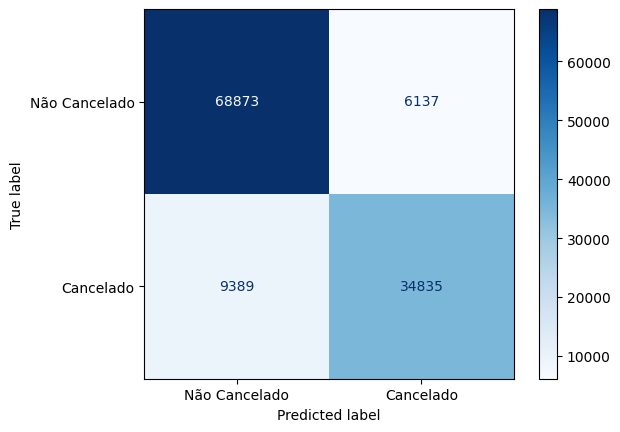

Score: 
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     75010
           1       0.85      0.79      0.82     44224

    accuracy                           0.87    119234
   macro avg       0.87      0.85      0.86    119234
weighted avg       0.87      0.87      0.87    119234



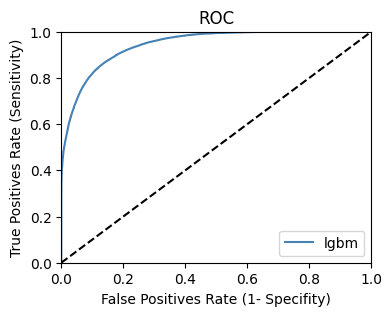

AUC: 0.9448




,0,1,2,3,4,mean_folds5,std
fit_time,0.2084,0.2255,0.1984,0.1975,0.1694,0.1999,0.0183
score_time,0.0294,0.0274,0.0286,0.0267,0.0265,0.0277,0.0011
test_Accuracy,0.8693,0.8666,0.8722,0.8717,0.8692,0.8698,0.0020
train_Accuracy,0.8720,0.8746,0.8739,0.8730,0.8747,0.8736,0.0010
test_Precision,0.8510,0.8441,0.8555,0.8530,0.8475,0.8502,0.0040
train_Precision,0.8551,0.8572,0.8571,0.8555,0.8557,0.8561,0.0009
test_Recall,0.7851,0.7853,0.7886,0.7902,0.7893,0.7877,0.0021
train_Recall,0.7885,0.7941,0.7922,0.7912,0.7964,0.7925,0.0027
test_F1,0.8167,0.8136,0.8207,0.8204,0.8174,0.8178,0.0026
train_F1,0.8204,0.8245,0.8233,0.8221,0.8250,0.8231,0.0016


In [325]:
y_prob, y_pred, scores  = CVS(lgbm,X,y,'lgbm')

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">XGboost</p></div>

In [326]:
xgb = XGBClassifier(random_state=RANDOM_SEED)

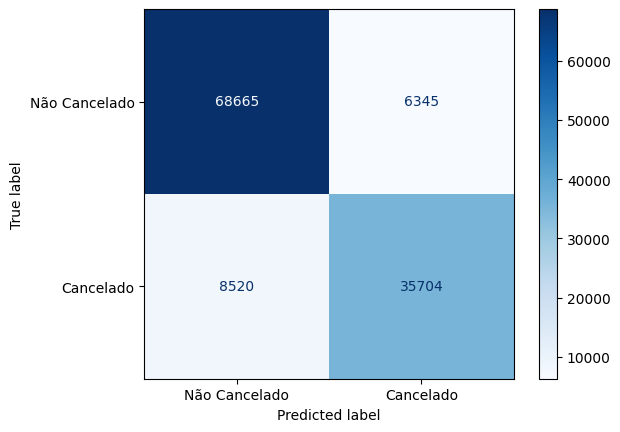

Score: 
               precision    recall  f1-score   support

           0       0.89      0.92      0.90     75010
           1       0.85      0.81      0.83     44224

    accuracy                           0.88    119234
   macro avg       0.87      0.86      0.87    119234
weighted avg       0.87      0.88      0.87    119234



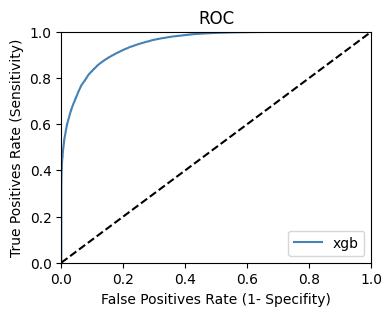

AUC: 0.9489




,0,1,2,3,4,mean_folds5,std
fit_time,1.4288,1.4445,1.2832,1.3587,1.2484,1.3527,0.0774
score_time,0.0237,0.0271,0.0232,0.0229,0.0229,0.0240,0.0016
test_Accuracy,0.8768,0.8714,0.8765,0.8758,0.8761,0.8753,0.0020
train_Accuracy,0.8913,0.8902,0.8891,0.8885,0.8906,0.8899,0.0010
test_Precision,0.8503,0.8417,0.8531,0.8516,0.8489,0.8491,0.0040
train_Precision,0.8703,0.8701,0.8678,0.8673,0.8690,0.8689,0.0012
test_Recall,0.8105,0.8047,0.8060,0.8054,0.8100,0.8073,0.0024
train_Recall,0.8306,0.8277,0.8268,0.8257,0.8303,0.8282,0.0019
test_F1,0.8299,0.8228,0.8289,0.8279,0.8290,0.8277,0.0025
train_F1,0.8500,0.8483,0.8468,0.8460,0.8492,0.8481,0.0015


In [327]:
y_prob, y_pred, scores  = CVS(xgb,X,y,'xgb')

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">ANN</p></div>

In [328]:
X_train_nn = torch.from_numpy(X_train.to_numpy()).float()
y_train_nn = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_val_nn = torch.from_numpy(X_val.to_numpy()).float()
y_val_nn = torch.squeeze(torch.from_numpy(y_val.to_numpy()).float())

In [329]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device
#device(type='cuda')

device(type='cpu')

In [330]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(95387, 19) (95387,)
(23847, 19) (23847,)


In [331]:
#batch_size = 64
#num_classes = 1

input_size = X.shape[1]
num_classes = 1
learning_rate = 0.01
hidden_size_1 = 200
hidden_size_2 = 400
dropout_rate = 0.1

In [332]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, dropout_rate):
        super(Net, self).__init__()
        self.hiden_layer1 = nn.Linear(input_size, hidden_size_1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.hiden_layer2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.output = nn.Linear(hidden_size_2, 1)
        
    def forward(self, x):
        x = torch.relu(self.hiden_layer1(x))
        x = self.dropout1(x)
        x = torch.relu(self.hiden_layer2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.output(x))
        return x

In [333]:
net = Net(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, dropout_rate=dropout_rate)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [334]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train_nn, y_train_nn = X_train_nn.to(device), y_train_nn.to(device)
X_val_nn, y_val_nn = X_val_nn.to(device), y_val_nn.to(device)

net = net.to(device)
criterion = criterion.to(device)

In [335]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    acc =  (y_true == predicted).sum().float() / len(y_true)
    
def calculate_f1(y_true, y_pred):
    # Converter probabilidades para classes
    predicted = y_pred.ge(.5).squeeze().long()
    y_true = y_true.long()

    # Calcular o F1 score
    f1 = f1_score(y_true, predicted, average='micro')

    return f1   

def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [336]:
# Definir número máximo de épocas sem melhora e contador de paciência
early_stop_epochs = 10
patience = 0
best_val_loss = float('inf')
num_epoch = 300

for epoch in range(num_epoch):
    y_pred = net(X_train_nn)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train_nn)
    if epoch % 10 == 0:
        train_score = calculate_f1(y_train_nn, y_pred)
        y_val_pred = net(X_val_nn)
        y_val_pred = torch.squeeze(y_val_pred)
        val_loss = criterion(y_val_pred, y_val_nn)
        val_score = calculate_f1(y_val_nn, y_val_pred)
        print(f'epoch {epoch} - train loss: {round_tensor(train_loss)}, train f1 : {round_tensor(train_score)} val loss: {round_tensor(val_loss)}, val f1: {round_tensor(val_score)}')
        # Verificar se houve melhora no conjunto de validação
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience >= early_stop_epochs:
                print('Early stopping')
                break
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0 - train loss: 16.26, train f1 : 0.623 val loss: 16.5, val f1: 0.622
epoch 10 - train loss: 62.91, train f1 : 0.371 val loss: 62.909, val f1: 0.371


KeyboardInterrupt: 

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Hypertuning</p></div> 

### <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Optuna</p></div>

In [337]:
weight = round(float((y.value_counts()[0])/(y.value_counts()[1])),3) #sum_neg/sum_p
weight

1.696

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM</p></div>

In [370]:
def objective(trial):
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary']),#binary         
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']), 
        'metric': trial.suggest_categorical('metric', ['f1']), 
        #'eval_metric': trial.suggest_categorical('eval_metric', ['f1']),   
        #"metric": "binary_error",
        "num_leaves": trial.suggest_int("num_leaves", 100, 300, step=20),
        "max_depth": trial.suggest_int("max_depth", 6, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        #'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 0.9),
        #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        #'is_unbalance': trial.suggest_categorical('is_unbalance', [False,True]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'boost_from_average': trial.suggest_categorical('boost_from_average', [False,True]),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,weight]),
        #'early_stopping_rounds':10,
        #'verbosity':0,
        'seed': RANDOM_SEED
    }
    
    model = LGBMClassifier(**param_grid)
    
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    scores = cross_val_score(model, X, y, cv=Kfold, scoring="f1")

    return scores.mean()

In [371]:
study = optuna.create_study(direction='maximize')
#optuna.logging.set_verbosity(optuna.logging.WARNING) 
#optuna.logging.set_verbosity(optuna.logging.DEBUG) 
study.optimize(objective, n_trials=100);

trial = study.best_trial

[I 2023-04-24 14:19:17,780] A new study created in memory with name: no-name-d57d8c36-8bfe-4c05-be50-3b861d785ce9


[LightGBM] [Warning] lambda_l1 is set=0.0025503671457099016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0025503671457099016
[LightGBM] [Warning] lambda_l2 is set=4.125237142937988e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.125237142937988e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=0.0025503671457099016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0025503671457099016
[LightGBM] [Warning] lambda_l2 is set=4.125237142937988e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.125237142937988e-08
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2023-04-24 14:19:20,124] Trial 0 finished with value: 0.7789884501365224 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 140, 'max_depth': 9, 'learning_rate': 0.005703494961059722, 'lambda_l1': 0.0025503671457099016, 'lambda_l2': 4.125237142937988e-08, 'bagging_freq': 0, 'min_child_samples': 34, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.7789884501365224.


[LightGBM] [Warning] lambda_l1 is set=0.000348474117022073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000348474117022073
[LightGBM] [Warning] lambda_l2 is set=0.007569277824098945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007569277824098945
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=0.000348474117022073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000348474117022073
[LightGBM] [Warning] lambda_l2 is set=0.007569277824098945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007569277824098945
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=0.000348474117022073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000348474117022073
[LightGBM] [Warning] lambda_l2 is set=0.007569277824098945, reg_lambda=0.0 will be ignored. C

[I 2023-04-24 14:19:21,552] Trial 1 finished with value: 0.8145081855924001 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 140, 'max_depth': 11, 'learning_rate': 0.01869121537106973, 'lambda_l1': 0.000348474117022073, 'lambda_l2': 0.007569277824098945, 'bagging_freq': 12, 'min_child_samples': 28, 'boost_from_average': False, 'scale_pos_weight': 1.696}. Best is trial 1 with value: 0.8145081855924001.


[LightGBM] [Warning] lambda_l1 is set=0.017831923918621945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017831923918621945
[LightGBM] [Warning] lambda_l2 is set=0.022557248586640165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.022557248586640165
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=0.017831923918621945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017831923918621945
[LightGBM] [Warning] lambda_l2 is set=0.022557248586640165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.022557248586640165
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=0.017831923918621945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017831923918621945
[LightGBM] [Warning] lambda_l2 is set=0.022557248586640165, reg_lambda=0.0 will be ignored. C

[I 2023-04-24 14:19:23,608] Trial 2 finished with value: 0.805170416041845 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 200, 'max_depth': 8, 'learning_rate': 0.06005638320997876, 'lambda_l1': 0.017831923918621945, 'lambda_l2': 0.022557248586640165, 'bagging_freq': 15, 'min_child_samples': 41, 'boost_from_average': False, 'scale_pos_weight': 1.696}. Best is trial 1 with value: 0.8145081855924001.


[LightGBM] [Warning] lambda_l1 is set=5.331672981817517e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.331672981817517e-06
[LightGBM] [Warning] lambda_l2 is set=8.301372816515424e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.301372816515424e-08
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=5.331672981817517e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.331672981817517e-06
[LightGBM] [Warning] lambda_l2 is set=8.301372816515424e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.301372816515424e-08
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=5.331672981817517e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.331672981817517e-06
[LightGBM] [Warning] lambda_l2 is set=8.301372816515424e-08, reg_lambda=0.0 will be

[I 2023-04-24 14:19:25,764] Trial 3 finished with value: 0.7903500634248845 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 140, 'max_depth': 11, 'learning_rate': 0.0036668504228077794, 'lambda_l1': 5.331672981817517e-06, 'lambda_l2': 8.301372816515424e-08, 'bagging_freq': 15, 'min_child_samples': 26, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 1 with value: 0.8145081855924001.


[LightGBM] [Warning] lambda_l1 is set=3.0154408866884103e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0154408866884103e-07
[LightGBM] [Warning] lambda_l2 is set=0.0034489612031801463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034489612031801463
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=3.0154408866884103e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0154408866884103e-07
[LightGBM] [Warning] lambda_l2 is set=0.0034489612031801463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034489612031801463
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=3.0154408866884103e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0154408866884103e-07
[LightGBM] [Warning] lambda_l2 is set=0.0034489612031801463, reg_lambda=0.0 w

[I 2023-04-24 14:19:27,212] Trial 4 finished with value: 0.8025959529736896 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 160, 'max_depth': 12, 'learning_rate': 0.002717904898873189, 'lambda_l1': 3.0154408866884103e-07, 'lambda_l2': 0.0034489612031801463, 'bagging_freq': 15, 'min_child_samples': 46, 'boost_from_average': False, 'scale_pos_weight': 1.696}. Best is trial 1 with value: 0.8145081855924001.


[LightGBM] [Warning] lambda_l1 is set=1.48118290661555e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.48118290661555e-06
[LightGBM] [Warning] lambda_l2 is set=3.214252123367752e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.214252123367752e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1.48118290661555e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.48118290661555e-06
[LightGBM] [Warning] lambda_l2 is set=3.214252123367752e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.214252123367752e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1.48118290661555e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.48118290661555e-06
[LightGBM] [Warning] lambda_l2 is set=3.214252123367752e-08, reg_lambda=0.0 will be ignored. 

[I 2023-04-24 14:19:28,732] Trial 5 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 10, 'learning_rate': 0.0010838915963153025, 'lambda_l1': 1.48118290661555e-06, 'lambda_l2': 3.214252123367752e-08, 'bagging_freq': 1, 'min_child_samples': 26, 'boost_from_average': True, 'scale_pos_weight': 1}. Best is trial 1 with value: 0.8145081855924001.


[LightGBM] [Warning] lambda_l1 is set=0.09908556706115716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09908556706115716
[LightGBM] [Warning] lambda_l2 is set=3.6637698900281816e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6637698900281816e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=0.09908556706115716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09908556706115716
[LightGBM] [Warning] lambda_l2 is set=3.6637698900281816e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6637698900281816e-08
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=0.09908556706115716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09908556706115716
[LightGBM] [Warning] lambda_l2 is set=3.6637698900281816e-08, reg_lambda=0.0 will be ignore

[I 2023-04-24 14:19:29,661] Trial 6 finished with value: 0.80160048484514 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 100, 'max_depth': 9, 'learning_rate': 0.025939655921615068, 'lambda_l1': 0.09908556706115716, 'lambda_l2': 3.6637698900281816e-08, 'bagging_freq': 13, 'min_child_samples': 42, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 1 with value: 0.8145081855924001.


[LightGBM] [Warning] lambda_l1 is set=9.401698247686506e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.401698247686506e-05
[LightGBM] [Warning] lambda_l2 is set=1.1454167194011902e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1454167194011902e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=9.401698247686506e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.401698247686506e-05
[LightGBM] [Warning] lambda_l2 is set=1.1454167194011902e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1454167194011902e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=9.401698247686506e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.401698247686506e-05
[LightGBM] [Warning] lambda_l2 is set=1.1454167194011902e-08, reg_lambda=0.0 will b

[I 2023-04-24 14:19:31,315] Trial 7 finished with value: 0.7947826547402718 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 10, 'learning_rate': 0.003907384180887114, 'lambda_l1': 9.401698247686506e-05, 'lambda_l2': 1.1454167194011902e-08, 'bagging_freq': 2, 'min_child_samples': 40, 'boost_from_average': False, 'scale_pos_weight': 1.696}. Best is trial 1 with value: 0.8145081855924001.


[LightGBM] [Warning] lambda_l1 is set=0.00010214884847169763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010214884847169763
[LightGBM] [Warning] lambda_l2 is set=1.0902144697573708e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0902144697573708e-05
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=0.00010214884847169763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010214884847169763
[LightGBM] [Warning] lambda_l2 is set=1.0902144697573708e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0902144697573708e-05
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=0.00010214884847169763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010214884847169763
[LightGBM] [Warning] lambda_l2 is set=1.0902144697573708e-05, reg_lambda=

[I 2023-04-24 14:19:33,007] Trial 8 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 180, 'max_depth': 7, 'learning_rate': 0.0012613997266815672, 'lambda_l1': 0.00010214884847169763, 'lambda_l2': 1.0902144697573708e-05, 'bagging_freq': 15, 'min_child_samples': 28, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 1 with value: 0.8145081855924001.


[LightGBM] [Warning] lambda_l1 is set=0.011933566207166912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011933566207166912
[LightGBM] [Warning] lambda_l2 is set=6.292891347794669e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.292891347794669e-07
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=0.011933566207166912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011933566207166912
[LightGBM] [Warning] lambda_l2 is set=6.292891347794669e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.292891347794669e-07
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=0.011933566207166912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011933566207166912
[LightGBM] [Warning] lambda_l2 is set=6.292891347794669e-07, reg_lambda=0.0 will be ignor

[I 2023-04-24 14:19:34,480] Trial 9 finished with value: 0.8124862282413646 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 180, 'max_depth': 12, 'learning_rate': 0.010621645251634048, 'lambda_l1': 0.011933566207166912, 'lambda_l2': 6.292891347794669e-07, 'bagging_freq': 11, 'min_child_samples': 30, 'boost_from_average': False, 'scale_pos_weight': 1.696}. Best is trial 1 with value: 0.8145081855924001.


[LightGBM] [Warning] lambda_l1 is set=2.0093534205765295e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0093534205765295e-08
[LightGBM] [Warning] lambda_l2 is set=0.6054706932587937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6054706932587937
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=2.0093534205765295e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0093534205765295e-08
[LightGBM] [Warning] lambda_l2 is set=0.6054706932587937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6054706932587937
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-04-24 14:19:35,088] Trial 10 finished with value: 0.8161846795871602 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 6, 'learning_rate': 0.09664048239077101, 'lambda_l1': 2.0093534205765295e-08, 'lambda_l2': 0.6054706932587937, 'bagging_freq': 6, 'min_child_samples': 13, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 10 with value: 0.8161846795871602.


[LightGBM] [Warning] lambda_l1 is set=2.0093534205765295e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0093534205765295e-08
[LightGBM] [Warning] lambda_l2 is set=0.6054706932587937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6054706932587937
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=1.725864371015271e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.725864371015271e-07
[LightGBM] [Warning] lambda_l2 is set=0.5615342740371468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5615342740371468
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=1.725864371015271e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.725864371015271e-07
[LightGBM] [Warning] lambda_l2 is set=0.5615342740371468, reg_lambda=0.0 will be ignored. Current

[I 2023-04-24 14:19:35,705] Trial 11 finished with value: 0.8154340571150213 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 6, 'learning_rate': 0.0942884470345111, 'lambda_l1': 1.725864371015271e-07, 'lambda_l2': 0.5615342740371468, 'bagging_freq': 7, 'min_child_samples': 10, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 10 with value: 0.8161846795871602.


[LightGBM] [Warning] lambda_l1 is set=1.0856047506090943e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0856047506090943e-08
[LightGBM] [Warning] lambda_l2 is set=0.5676574677861427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5676574677861427
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=1.0856047506090943e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0856047506090943e-08
[LightGBM] [Warning] lambda_l2 is set=0.5676574677861427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5676574677861427
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-24 14:19:36,303] Trial 12 finished with value: 0.815638993274807 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 6, 'learning_rate': 0.09438972531757316, 'lambda_l1': 1.0856047506090943e-08, 'lambda_l2': 0.5676574677861427, 'bagging_freq': 5, 'min_child_samples': 11, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 10 with value: 0.8161846795871602.


[LightGBM] [Warning] lambda_l1 is set=1.0856047506090943e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0856047506090943e-08
[LightGBM] [Warning] lambda_l2 is set=0.5676574677861427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5676574677861427
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=1.0152225932881784e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0152225932881784e-08
[LightGBM] [Warning] lambda_l2 is set=0.9241165907089685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9241165907089685
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=1.0152225932881784e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0152225932881784e-08
[LightGBM] [Warning] lambda_l2 is set=0.9241165907089685, reg_lambda=0.0 will be ignored. Cur

[I 2023-04-24 14:19:36,892] Trial 13 finished with value: 0.8023502373459183 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 6, 'learning_rate': 0.049712965646390356, 'lambda_l1': 1.0152225932881784e-08, 'lambda_l2': 0.9241165907089685, 'bagging_freq': 5, 'min_child_samples': 11, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 10 with value: 0.8161846795871602.


[LightGBM] [Warning] lambda_l1 is set=1.0152225932881784e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0152225932881784e-08
[LightGBM] [Warning] lambda_l2 is set=0.9241165907089685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9241165907089685
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=2.3794706750426965e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3794706750426965e-08
[LightGBM] [Warning] lambda_l2 is set=0.05627249475083797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05627249475083797
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=2.3794706750426965e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3794706750426965e-08
[LightGBM] [Warning] lambda_l2 is set=0.05627249475083797, reg_lambda=0.0 will be ignored. 

[I 2023-04-24 14:19:37,690] Trial 14 finished with value: 0.8231392332863728 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 7, 'learning_rate': 0.09632016623287154, 'lambda_l1': 2.3794706750426965e-08, 'lambda_l2': 0.05627249475083797, 'bagging_freq': 4, 'min_child_samples': 3, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=7.62097956459298e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.62097956459298e-08
[LightGBM] [Warning] lambda_l2 is set=0.0008804449175051337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008804449175051337
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l1 is set=7.62097956459298e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.62097956459298e-08
[LightGBM] [Warning] lambda_l2 is set=0.0008804449175051337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008804449175051337
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l1 is set=7.62097956459298e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.62097956459298e-08
[LightGBM] [Warning] lambda_l2 is set=0.0008804449175051337, reg_lambda=0.0 will be ignored. 

[I 2023-04-24 14:19:38,637] Trial 15 finished with value: 0.8039313438377738 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 7, 'learning_rate': 0.037184866379087196, 'lambda_l1': 7.62097956459298e-08, 'lambda_l2': 0.0008804449175051337, 'bagging_freq': 8, 'min_child_samples': 1, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=4.1810278029868765e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1810278029868765e-06
[LightGBM] [Warning] lambda_l2 is set=0.06342588234222597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06342588234222597
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=4.1810278029868765e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1810278029868765e-06
[LightGBM] [Warning] lambda_l2 is set=0.06342588234222597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06342588234222597
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=4.1810278029868765e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1810278029868765e-06
[LightGBM] [Warning] lambda_l2 is set=0.06342588234222597, reg_lambda=0.0 will be ignored

[I 2023-04-24 14:19:39,533] Trial 16 finished with value: 0.8226095023276973 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 7, 'learning_rate': 0.09934170654011909, 'lambda_l1': 4.1810278029868765e-06, 'lambda_l2': 0.06342588234222597, 'bagging_freq': 3, 'min_child_samples': 1, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=3.644057844908952e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.644057844908952e-06
[LightGBM] [Warning] lambda_l2 is set=0.03499215556318886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03499215556318886
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=3.644057844908952e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.644057844908952e-06
[LightGBM] [Warning] lambda_l2 is set=0.03499215556318886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03499215556318886
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=3.644057844908952e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.644057844908952e-06
[LightGBM] [Warning] lambda_l2 is set=0.03499215556318886, reg_lambda=0.0 will be ignored. Curr

[I 2023-04-24 14:19:40,624] Trial 17 finished with value: 0.8054309844988796 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 8, 'learning_rate': 0.021589517110873098, 'lambda_l1': 3.644057844908952e-06, 'lambda_l2': 0.03499215556318886, 'bagging_freq': 3, 'min_child_samples': 4, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=6.645492899449077e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.645492899449077e-07
[LightGBM] [Warning] lambda_l2 is set=0.00012601768975377284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012601768975377284
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=6.645492899449077e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.645492899449077e-07
[LightGBM] [Warning] lambda_l2 is set=0.00012601768975377284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012601768975377284
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=6.645492899449077e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.645492899449077e-07
[LightGBM] [Warning] lambda_l2 is set=0.00012601768975377284, reg_lambda=0.0 will b

[I 2023-04-24 14:19:44,455] Trial 18 finished with value: 0.7793679696582978 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 7, 'learning_rate': 0.05060427994566596, 'lambda_l1': 6.645492899449077e-07, 'lambda_l2': 0.00012601768975377284, 'bagging_freq': 3, 'min_child_samples': 19, 'boost_from_average': True, 'scale_pos_weight': 1}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=1.3923440525298574e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3923440525298574e-05
[LightGBM] [Warning] lambda_l2 is set=0.08166522356421314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08166522356421314
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=1.3923440525298574e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3923440525298574e-05
[LightGBM] [Warning] lambda_l2 is set=0.08166522356421314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08166522356421314
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=1.3923440525298574e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3923440525298574e-05
[LightGBM] [Warning] lambda_l2 is set=0.08166522356421314, reg_lambda=0.0 will be ignored

[I 2023-04-24 14:19:45,502] Trial 19 finished with value: 0.8106361974785297 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 8, 'learning_rate': 0.03423317152330958, 'lambda_l1': 1.3923440525298574e-05, 'lambda_l2': 0.08166522356421314, 'bagging_freq': 9, 'min_child_samples': 17, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=9.526077295151184e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.526077295151184e-08
[LightGBM] [Warning] lambda_l2 is set=0.0006990412319502498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006990412319502498
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=9.526077295151184e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.526077295151184e-08
[LightGBM] [Warning] lambda_l2 is set=0.0006990412319502498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006990412319502498
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=9.526077295151184e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.526077295151184e-08
[LightGBM] [Warning] lambda_l2 is set=0.0006990412319502498, reg_lambda=0.0 will be ign

[I 2023-04-24 14:19:46,322] Trial 20 finished with value: 0.7858592676373574 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 7, 'learning_rate': 0.01506603380614115, 'lambda_l1': 9.526077295151184e-08, 'lambda_l2': 0.0006990412319502498, 'bagging_freq': 4, 'min_child_samples': 5, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=4.982969659341466e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.982969659341466e-08
[LightGBM] [Warning] lambda_l2 is set=0.14147843159360415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14147843159360415
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=4.982969659341466e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.982969659341466e-08
[LightGBM] [Warning] lambda_l2 is set=0.14147843159360415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14147843159360415
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-24 14:19:46,911] Trial 21 finished with value: 0.8153126395288827 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 6, 'learning_rate': 0.08766782407671407, 'lambda_l1': 4.982969659341466e-08, 'lambda_l2': 0.14147843159360415, 'bagging_freq': 7, 'min_child_samples': 6, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=4.982969659341466e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.982969659341466e-08
[LightGBM] [Warning] lambda_l2 is set=0.14147843159360415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14147843159360415
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=8.877630616508488e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.877630616508488e-07
[LightGBM] [Warning] lambda_l2 is set=0.1287208145738689, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1287208145738689
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=8.877630616508488e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.877630616508488e-07
[LightGBM] [Warning] lambda_l2 is set=0.1287208145738689, reg_lambda=0.0 will be ignored. Current

[I 2023-04-24 14:19:47,698] Trial 22 finished with value: 0.8153044045403085 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 7, 'learning_rate': 0.06428413672581239, 'lambda_l1': 8.877630616508488e-07, 'lambda_l2': 0.1287208145738689, 'bagging_freq': 5, 'min_child_samples': 17, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=2.8024665650559337e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8024665650559337e-08
[LightGBM] [Warning] lambda_l2 is set=0.019059564446278033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019059564446278033
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=2.8024665650559337e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8024665650559337e-08
[LightGBM] [Warning] lambda_l2 is set=0.019059564446278033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019059564446278033
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=2.8024665650559337e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8024665650559337e-08
[LightGBM] [Warning] lambda_l2 is set=0.019059564446278033, reg_lambda=0.0 will be ig

[I 2023-04-24 14:19:48,741] Trial 23 finished with value: 0.8226337122196923 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 8, 'learning_rate': 0.06817168338981722, 'lambda_l1': 2.8024665650559337e-08, 'lambda_l2': 0.019059564446278033, 'bagging_freq': 6, 'min_child_samples': 1, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=2.1824120036901127e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1824120036901127e-07
[LightGBM] [Warning] lambda_l2 is set=0.009509475094895336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009509475094895336
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.1824120036901127e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1824120036901127e-07
[LightGBM] [Warning] lambda_l2 is set=0.009509475094895336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009509475094895336
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=2.1824120036901127e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1824120036901127e-07
[LightGBM] [Warning] lambda_l2 is set=0.009509475094895336, reg_lambda=0.0 will be ig

[I 2023-04-24 14:19:49,705] Trial 24 finished with value: 0.8129729439730022 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 8, 'learning_rate': 0.04001362115559861, 'lambda_l1': 2.1824120036901127e-07, 'lambda_l2': 0.009509475094895336, 'bagging_freq': 9, 'min_child_samples': 3, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=3.025437569606386e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.025437569606386e-08
[LightGBM] [Warning] lambda_l2 is set=0.027176397961263945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027176397961263945
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=3.025437569606386e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.025437569606386e-08
[LightGBM] [Warning] lambda_l2 is set=0.027176397961263945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027176397961263945
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=3.025437569606386e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.025437569606386e-08
[LightGBM] [Warning] lambda_l2 is set=0.027176397961263945, reg_lambda=0.0 will be ignored.

[I 2023-04-24 14:19:50,608] Trial 25 finished with value: 0.8215337655969442 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 8, 'learning_rate': 0.06516197025950614, 'lambda_l1': 3.025437569606386e-08, 'lambda_l2': 0.027176397961263945, 'bagging_freq': 3, 'min_child_samples': 7, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=5.651149278447742e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.651149278447742e-08
[LightGBM] [Warning] lambda_l2 is set=0.003023928677522537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003023928677522537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.651149278447742e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.651149278447742e-08
[LightGBM] [Warning] lambda_l2 is set=0.003023928677522537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003023928677522537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.651149278447742e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.651149278447742e-08
[LightGBM] [Warning] lambda_l2 is set=0.003023928677522537, reg_lambda=0.0 will be ignored.

[I 2023-04-24 14:19:53,770] Trial 26 finished with value: 0.7897627778398434 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 9, 'learning_rate': 0.02876834891590204, 'lambda_l1': 5.651149278447742e-08, 'lambda_l2': 0.003023928677522537, 'bagging_freq': 1, 'min_child_samples': 1, 'boost_from_average': True, 'scale_pos_weight': 1}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=3.9313951279547163e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9313951279547163e-07
[LightGBM] [Warning] lambda_l2 is set=0.13056474835140397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13056474835140397
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=3.9313951279547163e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9313951279547163e-07
[LightGBM] [Warning] lambda_l2 is set=0.13056474835140397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13056474835140397
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=3.9313951279547163e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9313951279547163e-07
[LightGBM] [Warning] lambda_l2 is set=0.13056474835140397, reg_lambda=0.0 will be ignored

[I 2023-04-24 14:19:54,473] Trial 27 finished with value: 0.816606011133414 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 200, 'max_depth': 7, 'learning_rate': 0.06657837933641284, 'lambda_l1': 3.9313951279547163e-07, 'lambda_l2': 0.13056474835140397, 'bagging_freq': 4, 'min_child_samples': 7, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=1.7765335423500041e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7765335423500041e-06
[LightGBM] [Warning] lambda_l2 is set=0.03989471326601393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03989471326601393
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=1.7765335423500041e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7765335423500041e-06
[LightGBM] [Warning] lambda_l2 is set=0.03989471326601393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03989471326601393
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=1.7765335423500041e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7765335423500041e-06
[LightGBM] [Warning] lambda_l2 is set=0.03989471326601393, reg_lambda=0.0 will be ignored

[I 2023-04-24 14:19:55,392] Trial 28 finished with value: 0.8160531934269857 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 8, 'learning_rate': 0.0463266881996821, 'lambda_l1': 1.7765335423500041e-06, 'lambda_l2': 0.03989471326601393, 'bagging_freq': 6, 'min_child_samples': 21, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=1.5796194370958181e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5796194370958181e-07
[LightGBM] [Warning] lambda_l2 is set=0.014517934306533522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014517934306533522
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=1.5796194370958181e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5796194370958181e-07
[LightGBM] [Warning] lambda_l2 is set=0.014517934306533522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014517934306533522
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=1.5796194370958181e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5796194370958181e-07
[LightGBM] [Warning] lambda_l2 is set=0.014517934306533522, reg_lambda=0.0 will be ig

[I 2023-04-24 14:19:58,113] Trial 29 finished with value: 0.7906727246439625 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 200, 'max_depth': 9, 'learning_rate': 0.032073165653906055, 'lambda_l1': 1.5796194370958181e-07, 'lambda_l2': 0.014517934306533522, 'bagging_freq': 0, 'min_child_samples': 14, 'boost_from_average': True, 'scale_pos_weight': 1}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=3.00245599535365e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.00245599535365e-08
[LightGBM] [Warning] lambda_l2 is set=0.0026861910961041738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026861910961041738
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=3.00245599535365e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.00245599535365e-08
[LightGBM] [Warning] lambda_l2 is set=0.0026861910961041738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026861910961041738
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=3.00245599535365e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.00245599535365e-08
[LightGBM] [Warning] lambda_l2 is set=0.0026861910961041738, reg_lambda=0.0 will be ignored. 

[I 2023-04-24 14:19:58,894] Trial 30 finished with value: 0.8182557014927094 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 7, 'learning_rate': 0.07668729646042836, 'lambda_l1': 3.00245599535365e-08, 'lambda_l2': 0.0026861910961041738, 'bagging_freq': 2, 'min_child_samples': 35, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=2.4490808414812035e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4490808414812035e-08
[LightGBM] [Warning] lambda_l2 is set=0.03040134667095464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03040134667095464
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=2.4490808414812035e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4490808414812035e-08
[LightGBM] [Warning] lambda_l2 is set=0.03040134667095464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03040134667095464
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=2.4490808414812035e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4490808414812035e-08
[LightGBM] [Warning] lambda_l2 is set=0.03040134667095464, reg_lambda=0.0 will be ignored

[I 2023-04-24 14:19:59,804] Trial 31 finished with value: 0.8225088105517558 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 8, 'learning_rate': 0.0664743627228051, 'lambda_l1': 2.4490808414812035e-08, 'lambda_l2': 0.03040134667095464, 'bagging_freq': 3, 'min_child_samples': 8, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=1.115271108761225e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.115271108761225e-08
[LightGBM] [Warning] lambda_l2 is set=0.2022042440725381, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2022042440725381
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=1.115271108761225e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.115271108761225e-08
[LightGBM] [Warning] lambda_l2 is set=0.2022042440725381, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2022042440725381
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=1.115271108761225e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.115271108761225e-08
[LightGBM] [Warning] lambda_l2 is set=0.2022042440725381, reg_lambda=0.0 will be ignored. Current v

[I 2023-04-24 14:20:00,727] Trial 32 finished with value: 0.8197847114678556 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 8, 'learning_rate': 0.056173990687531136, 'lambda_l1': 1.115271108761225e-08, 'lambda_l2': 0.2022042440725381, 'bagging_freq': 4, 'min_child_samples': 2, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 14 with value: 0.8231392332863728.


[LightGBM] [Warning] lambda_l1 is set=6.358121933815503e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.358121933815503e-08
[LightGBM] [Warning] lambda_l2 is set=0.011697586451792906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011697586451792906
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=6.358121933815503e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.358121933815503e-08
[LightGBM] [Warning] lambda_l2 is set=0.011697586451792906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011697586451792906
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=6.358121933815503e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.358121933815503e-08
[LightGBM] [Warning] lambda_l2 is set=0.011697586451792906, reg_lambda=0.0 will be ignored.

[I 2023-04-24 14:20:01,817] Trial 33 finished with value: 0.8287341050250342 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 9, 'learning_rate': 0.0732874911895967, 'lambda_l1': 6.358121933815503e-08, 'lambda_l2': 0.011697586451792906, 'bagging_freq': 2, 'min_child_samples': 9, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 33 with value: 0.8287341050250342.


[LightGBM] [Warning] lambda_l1 is set=9.283973202943212e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.283973202943212e-08
[LightGBM] [Warning] lambda_l2 is set=0.008793312624038868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008793312624038868
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=9.283973202943212e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.283973202943212e-08
[LightGBM] [Warning] lambda_l2 is set=0.008793312624038868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008793312624038868
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=9.283973202943212e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.283973202943212e-08
[LightGBM] [Warning] lambda_l2 is set=0.008793312624038868, reg_lambda=0.0 will be ignored.

[I 2023-04-24 14:20:03,049] Trial 34 finished with value: 0.8357141191657053 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 10, 'learning_rate': 0.0991665160729048, 'lambda_l1': 9.283973202943212e-08, 'lambda_l2': 0.008793312624038868, 'bagging_freq': 0, 'min_child_samples': 1, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 34 with value: 0.8357141191657053.


[LightGBM] [Warning] lambda_l1 is set=3.7809413493585095e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7809413493585095e-07
[LightGBM] [Warning] lambda_l2 is set=0.008408538070375574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008408538070375574
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=3.7809413493585095e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7809413493585095e-07
[LightGBM] [Warning] lambda_l2 is set=0.008408538070375574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008408538070375574
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=3.7809413493585095e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7809413493585095e-07
[LightGBM] [Warning] lambda_l2 is set=0.008408538070375574, reg_lambda=0.0 will be ig

[I 2023-04-24 14:20:05,690] Trial 35 finished with value: 0.8165946960218763 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 10, 'learning_rate': 0.04689628225973074, 'lambda_l1': 3.7809413493585095e-07, 'lambda_l2': 0.008408538070375574, 'bagging_freq': 0, 'min_child_samples': 9, 'boost_from_average': False, 'scale_pos_weight': 1.696}. Best is trial 34 with value: 0.8357141191657053.


[LightGBM] [Warning] lambda_l1 is set=6.994452975406343e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.994452975406343e-08
[LightGBM] [Warning] lambda_l2 is set=0.007055375981301083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007055375981301083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=6.994452975406343e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.994452975406343e-08
[LightGBM] [Warning] lambda_l2 is set=0.007055375981301083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007055375981301083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=6.994452975406343e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.994452975406343e-08
[LightGBM] [Warning] lambda_l2 is set=0.007055375981301083, reg_lambda=0.0 will be ignored.

[I 2023-04-24 14:20:07,210] Trial 36 finished with value: 0.8364433158780381 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 11, 'learning_rate': 0.07722776257316503, 'lambda_l1': 6.994452975406343e-08, 'lambda_l2': 0.007055375981301083, 'bagging_freq': 1, 'min_child_samples': 5, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.0037283472298532e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0037283472298532e-07
[LightGBM] [Warning] lambda_l2 is set=0.006043722671875708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006043722671875708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1.0037283472298532e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0037283472298532e-07
[LightGBM] [Warning] lambda_l2 is set=0.006043722671875708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006043722671875708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1.0037283472298532e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0037283472298532e-07
[LightGBM] [Warning] lambda_l2 is set=0.006043722671875708, reg_lambda=0.0 will be ig

[I 2023-04-24 14:20:08,547] Trial 37 finished with value: 0.8316352912004347 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 180, 'max_depth': 11, 'learning_rate': 0.07865357784264188, 'lambda_l1': 1.0037283472298532e-07, 'lambda_l2': 0.006043722671875708, 'bagging_freq': 1, 'min_child_samples': 5, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.0931801456762735e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0931801456762735e-07
[LightGBM] [Warning] lambda_l2 is set=0.0054541410350182635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0054541410350182635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1.0931801456762735e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0931801456762735e-07
[LightGBM] [Warning] lambda_l2 is set=0.0054541410350182635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0054541410350182635
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1.0931801456762735e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0931801456762735e-07
[LightGBM] [Warning] lambda_l2 is set=0.0054541410350182635, reg_lambda=0.0 will 

[I 2023-04-24 14:20:09,747] Trial 38 finished with value: 0.819582547658459 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 160, 'max_depth': 11, 'learning_rate': 0.038532230733083796, 'lambda_l1': 1.0931801456762735e-07, 'lambda_l2': 0.0054541410350182635, 'bagging_freq': 1, 'min_child_samples': 23, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=5.437711288531634e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.437711288531634e-07
[LightGBM] [Warning] lambda_l2 is set=0.0009705497281133768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009705497281133768
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=5.437711288531634e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.437711288531634e-07
[LightGBM] [Warning] lambda_l2 is set=0.0009705497281133768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009705497281133768
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=5.437711288531634e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.437711288531634e-07
[LightGBM] [Warning] lambda_l2 is set=0.0009705497281133768, reg_lambda=0.0 will be ign

[I 2023-04-24 14:20:12,332] Trial 39 finished with value: 0.8184345689843443 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 180, 'max_depth': 11, 'learning_rate': 0.07874435520342556, 'lambda_l1': 5.437711288531634e-07, 'lambda_l2': 0.0009705497281133768, 'bagging_freq': 0, 'min_child_samples': 14, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.8341448170614413e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8341448170614413e-07
[LightGBM] [Warning] lambda_l2 is set=0.0026060635679461823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026060635679461823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1.8341448170614413e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8341448170614413e-07
[LightGBM] [Warning] lambda_l2 is set=0.0026060635679461823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026060635679461823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1.8341448170614413e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8341448170614413e-07
[LightGBM] [Warning] lambda_l2 is set=0.0026060635679461823, reg_lambda=0.0 will 

[I 2023-04-24 14:20:13,367] Trial 40 finished with value: 0.8213457143957775 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 100, 'max_depth': 10, 'learning_rate': 0.054234378988361316, 'lambda_l1': 1.8341448170614413e-07, 'lambda_l2': 0.0026060635679461823, 'bagging_freq': 1, 'min_child_samples': 5, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=7.08111297728191e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.08111297728191e-08
[LightGBM] [Warning] lambda_l2 is set=0.012394645422624551, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012394645422624551
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=7.08111297728191e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.08111297728191e-08
[LightGBM] [Warning] lambda_l2 is set=0.012394645422624551, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012394645422624551
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=7.08111297728191e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.08111297728191e-08
[LightGBM] [Warning] lambda_l2 is set=0.012394645422624551, reg_lambda=0.0 will be ignored. Curre

[I 2023-04-24 14:20:15,008] Trial 41 finished with value: 0.8331611341554401 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 200, 'max_depth': 12, 'learning_rate': 0.07306166601436033, 'lambda_l1': 7.08111297728191e-08, 'lambda_l2': 0.012394645422624551, 'bagging_freq': 2, 'min_child_samples': 5, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=7.35391387662474e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.35391387662474e-08
[LightGBM] [Warning] lambda_l2 is set=0.009110418585761454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009110418585761454
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=7.35391387662474e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.35391387662474e-08
[LightGBM] [Warning] lambda_l2 is set=0.009110418585761454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009110418585761454
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=7.35391387662474e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.35391387662474e-08
[LightGBM] [Warning] lambda_l2 is set=0.009110418585761454, reg_lambda=0.0 will be ignored. Curre

[I 2023-04-24 14:20:16,375] Trial 42 finished with value: 0.831517349281614 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 200, 'max_depth': 12, 'learning_rate': 0.07583842708745599, 'lambda_l1': 7.35391387662474e-08, 'lambda_l2': 0.009110418585761454, 'bagging_freq': 2, 'min_child_samples': 50, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.1109913636251374e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1109913636251374e-06
[LightGBM] [Warning] lambda_l2 is set=0.005371803842802514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005371803842802514
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=1.1109913636251374e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1109913636251374e-06
[LightGBM] [Warning] lambda_l2 is set=0.005371803842802514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005371803842802514
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=1.1109913636251374e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1109913636251374e-06
[LightGBM] [Warning] lambda_l2 is set=0.005371803842802514, reg_lambda=0.0 will be ig

[I 2023-04-24 14:20:17,645] Trial 43 finished with value: 0.8306978362396492 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 160, 'max_depth': 12, 'learning_rate': 0.07463355611420343, 'lambda_l1': 1.1109913636251374e-06, 'lambda_l2': 0.005371803842802514, 'bagging_freq': 2, 'min_child_samples': 47, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=2.536661654285492e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.536661654285492e-07
[LightGBM] [Warning] lambda_l2 is set=0.0015959045369801778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015959045369801778
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=2.536661654285492e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.536661654285492e-07
[LightGBM] [Warning] lambda_l2 is set=0.0015959045369801778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015959045369801778
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=2.536661654285492e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.536661654285492e-07
[LightGBM] [Warning] lambda_l2 is set=0.0015959045369801778, reg_lambda=0.0 will be ign

[I 2023-04-24 14:20:19,004] Trial 44 finished with value: 0.8237579624459613 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 200, 'max_depth': 12, 'learning_rate': 0.04311217892352232, 'lambda_l1': 2.536661654285492e-07, 'lambda_l2': 0.0015959045369801778, 'bagging_freq': 0, 'min_child_samples': 34, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=9.684279184180456e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.684279184180456e-08
[LightGBM] [Warning] lambda_l2 is set=0.0004661569567598209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004661569567598209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=9.684279184180456e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.684279184180456e-08
[LightGBM] [Warning] lambda_l2 is set=0.0004661569567598209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004661569567598209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=9.684279184180456e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.684279184180456e-08
[LightGBM] [Warning] lambda_l2 is set=0.0004661569567598209, reg_lambda=0.0 will be ign

[I 2023-04-24 14:20:20,248] Trial 45 finished with value: 0.8270378607313918 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 180, 'max_depth': 11, 'learning_rate': 0.059923877687013974, 'lambda_l1': 9.684279184180456e-08, 'lambda_l2': 0.0004661569567598209, 'bagging_freq': 1, 'min_child_samples': 38, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=3.9338838059774597e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9338838059774597e-07
[LightGBM] [Warning] lambda_l2 is set=0.00031018366582450405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031018366582450405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=3.9338838059774597e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9338838059774597e-07
[LightGBM] [Warning] lambda_l2 is set=0.00031018366582450405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031018366582450405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=3.9338838059774597e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9338838059774597e-07
[LightGBM] [Warning] lambda_l2 is set=0.00031018366582450405, reg_lambda=0.0 

[I 2023-04-24 14:20:21,482] Trial 46 finished with value: 0.83122312268054 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 140, 'max_depth': 12, 'learning_rate': 0.08263824917698404, 'lambda_l1': 3.9338838059774597e-07, 'lambda_l2': 0.00031018366582450405, 'bagging_freq': 1, 'min_child_samples': 43, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=2.086228225013908e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.086228225013908e-06
[LightGBM] [Warning] lambda_l2 is set=0.004910237594160181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004910237594160181
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=2.086228225013908e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.086228225013908e-06
[LightGBM] [Warning] lambda_l2 is set=0.004910237594160181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004910237594160181
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=2.086228225013908e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.086228225013908e-06
[LightGBM] [Warning] lambda_l2 is set=0.004910237594160181, reg_lambda=0.0 will be ignored.

[I 2023-04-24 14:20:22,964] Trial 47 finished with value: 0.8124162436642459 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 180, 'max_depth': 11, 'learning_rate': 0.025625771998541554, 'lambda_l1': 2.086228225013908e-06, 'lambda_l2': 0.004910237594160181, 'bagging_freq': 2, 'min_child_samples': 49, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.87843562192061e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.87843562192061e-05
[LightGBM] [Warning] lambda_l2 is set=0.015646935810385326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015646935810385326
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=1.87843562192061e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.87843562192061e-05
[LightGBM] [Warning] lambda_l2 is set=0.015646935810385326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015646935810385326
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=1.87843562192061e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.87843562192061e-05
[LightGBM] [Warning] lambda_l2 is set=0.015646935810385326, reg_lambda=0.0 will be ignored. Curre

[I 2023-04-24 14:20:24,382] Trial 48 finished with value: 0.8272208412113825 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 200, 'max_depth': 11, 'learning_rate': 0.055807377230117736, 'lambda_l1': 1.87843562192061e-05, 'lambda_l2': 0.015646935810385326, 'bagging_freq': 0, 'min_child_samples': 12, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=4.767596933437705e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.767596933437705e-08
[LightGBM] [Warning] lambda_l2 is set=0.001824102406989944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001824102406989944
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=4.767596933437705e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.767596933437705e-08
[LightGBM] [Warning] lambda_l2 is set=0.001824102406989944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001824102406989944
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=4.767596933437705e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.767596933437705e-08
[LightGBM] [Warning] lambda_l2 is set=0.001824102406989944, reg_lambda=0.0 will be ignored.

[I 2023-04-24 14:20:25,808] Trial 49 finished with value: 0.8335403513643471 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 12, 'learning_rate': 0.08201809781645387, 'lambda_l1': 4.767596933437705e-08, 'lambda_l2': 0.001824102406989944, 'bagging_freq': 2, 'min_child_samples': 29, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=7.369452968094296e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.369452968094296e-07
[LightGBM] [Warning] lambda_l2 is set=0.0019931371220527883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019931371220527883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=7.369452968094296e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.369452968094296e-07
[LightGBM] [Warning] lambda_l2 is set=0.0019931371220527883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019931371220527883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=7.369452968094296e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.369452968094296e-07
[LightGBM] [Warning] lambda_l2 is set=0.0019931371220527883, reg_lambda=0.0 will be ign

[I 2023-04-24 14:20:28,360] Trial 50 finished with value: 0.8180328401589035 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 10, 'learning_rate': 0.09690304552226617, 'lambda_l1': 7.369452968094296e-07, 'lambda_l2': 0.0019931371220527883, 'bagging_freq': 1, 'min_child_samples': 23, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=5.931532591160443e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.931532591160443e-08
[LightGBM] [Warning] lambda_l2 is set=0.007005475899953893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007005475899953893
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=5.931532591160443e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.931532591160443e-08
[LightGBM] [Warning] lambda_l2 is set=0.007005475899953893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007005475899953893
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=5.931532591160443e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.931532591160443e-08
[LightGBM] [Warning] lambda_l2 is set=0.007005475899953893, reg_lambda=0.0 will be ignored.

[I 2023-04-24 14:20:29,819] Trial 51 finished with value: 0.8340090597281239 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 12, 'learning_rate': 0.08360987575548247, 'lambda_l1': 5.931532591160443e-08, 'lambda_l2': 0.007005475899953893, 'bagging_freq': 2, 'min_child_samples': 35, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.4542220702734408e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4542220702734408e-07
[LightGBM] [Warning] lambda_l2 is set=0.001482328318663877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001482328318663877
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=1.4542220702734408e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4542220702734408e-07
[LightGBM] [Warning] lambda_l2 is set=0.001482328318663877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001482328318663877
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=1.4542220702734408e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4542220702734408e-07
[LightGBM] [Warning] lambda_l2 is set=0.001482328318663877, reg_lambda=0.0 will be ig

[I 2023-04-24 14:20:31,222] Trial 52 finished with value: 0.8333590217772245 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 12, 'learning_rate': 0.08368918193183492, 'lambda_l1': 1.4542220702734408e-07, 'lambda_l2': 0.001482328318663877, 'bagging_freq': 0, 'min_child_samples': 30, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.0666001520448022e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0666001520448022e-08
[LightGBM] [Warning] lambda_l2 is set=0.0012272700310980286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012272700310980286
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=1.0666001520448022e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0666001520448022e-08
[LightGBM] [Warning] lambda_l2 is set=0.0012272700310980286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012272700310980286
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=1.0666001520448022e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0666001520448022e-08
[LightGBM] [Warning] lambda_l2 is set=0.0012272700310980286, reg_lambda=0.0 will 

[I 2023-04-24 14:20:32,695] Trial 53 finished with value: 0.8282129345134521 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 12, 'learning_rate': 0.05399855094716134, 'lambda_l1': 1.0666001520448022e-08, 'lambda_l2': 0.0012272700310980286, 'bagging_freq': 0, 'min_child_samples': 30, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=4.765267953543266e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.765267953543266e-08
[LightGBM] [Warning] lambda_l2 is set=0.00018179666678838787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018179666678838787
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=4.765267953543266e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.765267953543266e-08
[LightGBM] [Warning] lambda_l2 is set=0.00018179666678838787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018179666678838787
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=4.765267953543266e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.765267953543266e-08
[LightGBM] [Warning] lambda_l2 is set=0.00018179666678838787, reg_lambda=0.0 will b

[I 2023-04-24 14:20:34,123] Trial 54 finished with value: 0.8363939588362692 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 12, 'learning_rate': 0.09882797963101922, 'lambda_l1': 4.765267953543266e-08, 'lambda_l2': 0.00018179666678838787, 'bagging_freq': 2, 'min_child_samples': 33, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=4.145134629022685e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.145134629022685e-08
[LightGBM] [Warning] lambda_l2 is set=0.0001554420304533931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001554420304533931
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=4.145134629022685e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.145134629022685e-08
[LightGBM] [Warning] lambda_l2 is set=0.0001554420304533931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001554420304533931
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=4.145134629022685e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.145134629022685e-08
[LightGBM] [Warning] lambda_l2 is set=0.0001554420304533931, reg_lambda=0.0 will be

[I 2023-04-24 14:20:35,621] Trial 55 finished with value: 0.8353350991781435 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 12, 'learning_rate': 0.090457589199318, 'lambda_l1': 4.145134629022685e-08, 'lambda_l2': 0.0001554420304533931, 'bagging_freq': 12, 'min_child_samples': 32, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=4.56691412862977e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.56691412862977e-08
[LightGBM] [Warning] lambda_l2 is set=4.809477878756019e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.809477878756019e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=4.56691412862977e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.56691412862977e-08
[LightGBM] [Warning] lambda_l2 is set=4.809477878756019e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.809477878756019e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=4.56691412862977e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.56691412862977e-08
[LightGBM] [Warning] lambda_l2 is set=4.809477878756019e-05, reg_lambda=0.0 will be ignor

[I 2023-04-24 14:20:37,151] Trial 56 finished with value: 0.8343998569804586 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 12, 'learning_rate': 0.0865875439063757, 'lambda_l1': 4.56691412862977e-08, 'lambda_l2': 4.809477878756019e-05, 'bagging_freq': 13, 'min_child_samples': 34, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.7273542013720553e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7273542013720553e-08
[LightGBM] [Warning] lambda_l2 is set=3.813580290000468e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.813580290000468e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=1.7273542013720553e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7273542013720553e-08
[LightGBM] [Warning] lambda_l2 is set=3.813580290000468e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.813580290000468e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=1.7273542013720553e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7273542013720553e-08
[LightGBM] [Warning] lambda_l2 is set=3.813580290000468e-05, reg_lambda=0.0 w

[I 2023-04-24 14:20:38,769] Trial 57 finished with value: 0.8335113874366424 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 11, 'learning_rate': 0.0959328677401327, 'lambda_l1': 1.7273542013720553e-08, 'lambda_l2': 3.813580290000468e-05, 'bagging_freq': 13, 'min_child_samples': 34, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=3.789956293673075e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.789956293673075e-08
[LightGBM] [Warning] lambda_l2 is set=0.00025576379077205986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025576379077205986
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=3.789956293673075e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.789956293673075e-08
[LightGBM] [Warning] lambda_l2 is set=0.00025576379077205986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025576379077205986
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=3.789956293673075e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.789956293673075e-08
[LightGBM] [Warning] lambda_l2 is set=0.00025576379077205986, reg_lambda=0.0 wi

[I 2023-04-24 14:20:40,414] Trial 58 finished with value: 0.8254351264280612 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 12, 'learning_rate': 0.04435686489721989, 'lambda_l1': 3.789956293673075e-08, 'lambda_l2': 0.00025576379077205986, 'bagging_freq': 14, 'min_child_samples': 32, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.826661769818141e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.826661769818141e-08
[LightGBM] [Warning] lambda_l2 is set=3.0881340683144264e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0881340683144264e-05
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=1.826661769818141e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.826661769818141e-08
[LightGBM] [Warning] lambda_l2 is set=3.0881340683144264e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0881340683144264e-05
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=1.826661769818141e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.826661769818141e-08
[LightGBM] [Warning] lambda_l2 is set=3.0881340683144264e-05, reg_lambda=0.0 wi

[I 2023-04-24 14:20:41,898] Trial 59 finished with value: 0.8331480899965155 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 11, 'learning_rate': 0.09833933200682642, 'lambda_l1': 1.826661769818141e-08, 'lambda_l2': 3.0881340683144264e-05, 'bagging_freq': 12, 'min_child_samples': 38, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=3.0018950284584195e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0018950284584195e-07
[LightGBM] [Warning] lambda_l2 is set=0.00016016555873922897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016016555873922897
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=3.0018950284584195e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0018950284584195e-07
[LightGBM] [Warning] lambda_l2 is set=0.00016016555873922897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016016555873922897
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=3.0018950284584195e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0018950284584195e-07
[LightGBM] [Warning] lambda_l2 is set=0.00016016555873922897, reg_lambda=

[I 2023-04-24 14:20:43,487] Trial 60 finished with value: 0.829804392313624 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 12, 'learning_rate': 0.059287951528654646, 'lambda_l1': 3.0018950284584195e-07, 'lambda_l2': 0.00016016555873922897, 'bagging_freq': 11, 'min_child_samples': 37, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=4.261108297340387e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.261108297340387e-08
[LightGBM] [Warning] lambda_l2 is set=0.0005810682656299979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005810682656299979
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=4.261108297340387e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.261108297340387e-08
[LightGBM] [Warning] lambda_l2 is set=0.0005810682656299979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005810682656299979
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=4.261108297340387e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.261108297340387e-08
[LightGBM] [Warning] lambda_l2 is set=0.0005810682656299979, reg_lambda=0.0 will be

[I 2023-04-24 14:20:45,258] Trial 61 finished with value: 0.8344071548565551 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 12, 'learning_rate': 0.08533419785530018, 'lambda_l1': 4.261108297340387e-08, 'lambda_l2': 0.0005810682656299979, 'bagging_freq': 14, 'min_child_samples': 28, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=3.998122182983251e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.998122182983251e-08
[LightGBM] [Warning] lambda_l2 is set=0.0006873088661652426, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006873088661652426
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=3.998122182983251e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.998122182983251e-08
[LightGBM] [Warning] lambda_l2 is set=0.0006873088661652426, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006873088661652426
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=3.998122182983251e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.998122182983251e-08
[LightGBM] [Warning] lambda_l2 is set=0.0006873088661652426, reg_lambda=0.0 will be

[I 2023-04-24 14:20:47,032] Trial 62 finished with value: 0.8359576010578259 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 12, 'learning_rate': 0.09900205188150714, 'lambda_l1': 3.998122182983251e-08, 'lambda_l2': 0.0006873088661652426, 'bagging_freq': 15, 'min_child_samples': 26, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=3.6000319247011236e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6000319247011236e-08
[LightGBM] [Warning] lambda_l2 is set=0.0005305614224914634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005305614224914634
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=3.6000319247011236e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6000319247011236e-08
[LightGBM] [Warning] lambda_l2 is set=0.0005305614224914634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005305614224914634
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=3.6000319247011236e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6000319247011236e-08
[LightGBM] [Warning] lambda_l2 is set=0.0005305614224914634, reg_lambda=0.0 w

[I 2023-04-24 14:20:48,973] Trial 63 finished with value: 0.8361681646457035 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 12, 'learning_rate': 0.09737184890465239, 'lambda_l1': 3.6000319247011236e-08, 'lambda_l2': 0.0005305614224914634, 'bagging_freq': 14, 'min_child_samples': 26, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.9046151753652104e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9046151753652104e-08
[LightGBM] [Warning] lambda_l2 is set=0.0006454791273005435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006454791273005435
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=1.9046151753652104e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9046151753652104e-08
[LightGBM] [Warning] lambda_l2 is set=0.0006454791273005435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006454791273005435
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=1.9046151753652104e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9046151753652104e-08
[LightGBM] [Warning] lambda_l2 is set=0.0006454791273005435, reg_lambda=0.0 w

[I 2023-04-24 14:20:50,639] Trial 64 finished with value: 0.8309126431915766 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 12, 'learning_rate': 0.06378458944520309, 'lambda_l1': 1.9046151753652104e-08, 'lambda_l2': 0.0006454791273005435, 'bagging_freq': 15, 'min_child_samples': 27, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.6703176819816133e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6703176819816133e-07
[LightGBM] [Warning] lambda_l2 is set=0.000443967829380479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000443967829380479
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=1.6703176819816133e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6703176819816133e-07
[LightGBM] [Warning] lambda_l2 is set=0.000443967829380479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000443967829380479
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=1.6703176819816133e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6703176819816133e-07
[LightGBM] [Warning] lambda_l2 is set=0.000443967829380479, reg_lambda=0.0 will b

[I 2023-04-24 14:20:51,864] Trial 65 finished with value: 0.83158576626565 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 10, 'learning_rate': 0.09705983296242861, 'lambda_l1': 1.6703176819816133e-07, 'lambda_l2': 0.000443967829380479, 'bagging_freq': 14, 'min_child_samples': 26, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.7171008178308798e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7171008178308798e-08
[LightGBM] [Warning] lambda_l2 is set=8.57532580694266e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57532580694266e-05
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=1.7171008178308798e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7171008178308798e-08
[LightGBM] [Warning] lambda_l2 is set=8.57532580694266e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57532580694266e-05
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=1.7171008178308798e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7171008178308798e-08
[LightGBM] [Warning] lambda_l2 is set=8.57532580694266e-05, reg_lambda=0.0 will b

[I 2023-04-24 14:20:53,444] Trial 66 finished with value: 0.8285576331178216 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 11, 'learning_rate': 0.06403773928350034, 'lambda_l1': 1.7171008178308798e-08, 'lambda_l2': 8.57532580694266e-05, 'bagging_freq': 14, 'min_child_samples': 24, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=3.5723221380444566e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5723221380444566e-08
[LightGBM] [Warning] lambda_l2 is set=0.0002381165586072678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002381165586072678
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=3.5723221380444566e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5723221380444566e-08
[LightGBM] [Warning] lambda_l2 is set=0.0002381165586072678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002381165586072678
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=3.5723221380444566e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5723221380444566e-08
[LightGBM] [Warning] lambda_l2 is set=0.0002381165586072678, reg_lambda=0.0 w

[I 2023-04-24 14:20:54,801] Trial 67 finished with value: 0.8340394747676774 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 220, 'max_depth': 11, 'learning_rate': 0.09958064663036313, 'lambda_l1': 3.5723221380444566e-08, 'lambda_l2': 0.0002381165586072678, 'bagging_freq': 12, 'min_child_samples': 31, 'boost_from_average': False, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=1.2154559121527921e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2154559121527921e-07
[LightGBM] [Warning] lambda_l2 is set=0.0008319531408934208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008319531408934208
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=1.2154559121527921e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2154559121527921e-07
[LightGBM] [Warning] lambda_l2 is set=0.0008319531408934208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008319531408934208
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=1.2154559121527921e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2154559121527921e-07
[LightGBM] [Warning] lambda_l2 is set=0.0008319531408934208, reg_lambda=0.0 w

[I 2023-04-24 14:20:57,967] Trial 68 finished with value: 0.8207198452640556 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 12, 'learning_rate': 0.05044316173559738, 'lambda_l1': 1.2154559121527921e-07, 'lambda_l2': 0.0008319531408934208, 'bagging_freq': 15, 'min_child_samples': 28, 'boost_from_average': False, 'scale_pos_weight': 1.696}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=2.3316694681963747e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3316694681963747e-07
[LightGBM] [Warning] lambda_l2 is set=0.00045991854356528097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00045991854356528097
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=2.3316694681963747e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3316694681963747e-07
[LightGBM] [Warning] lambda_l2 is set=0.00045991854356528097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00045991854356528097
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=2.3316694681963747e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3316694681963747e-07
[LightGBM] [Warning] lambda_l2 is set=0.00045991854356528097, reg_lambda=

[I 2023-04-24 14:20:59,506] Trial 69 finished with value: 0.8314082785077198 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 240, 'max_depth': 12, 'learning_rate': 0.06843497162813121, 'lambda_l1': 2.3316694681963747e-07, 'lambda_l2': 0.00045991854356528097, 'bagging_freq': 13, 'min_child_samples': 25, 'boost_from_average': True, 'scale_pos_weight': 1}. Best is trial 36 with value: 0.8364433158780381.


[LightGBM] [Warning] lambda_l1 is set=3.514680297463857e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.514680297463857e-08
[LightGBM] [Warning] lambda_l2 is set=0.00014333279506656164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014333279506656164
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=3.514680297463857e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.514680297463857e-08
[LightGBM] [Warning] lambda_l2 is set=0.00014333279506656164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014333279506656164
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=3.514680297463857e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.514680297463857e-08
[LightGBM] [Warning] lambda_l2 is set=0.00014333279506656164, reg_lambda=0.0 wi

[I 2023-04-24 14:21:00,946] Trial 70 finished with value: 0.8370544117681601 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 11, 'learning_rate': 0.08922892879135912, 'lambda_l1': 3.514680297463857e-08, 'lambda_l2': 0.00014333279506656164, 'bagging_freq': 14, 'min_child_samples': 21, 'boost_from_average': False, 'scale_pos_weight': 1.696}. Best is trial 70 with value: 0.8370544117681601.


[LightGBM] [Warning] lambda_l1 is set=3.306880745319498e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.306880745319498e-08
[LightGBM] [Warning] lambda_l2 is set=0.00015597340282366633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015597340282366633
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=3.306880745319498e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.306880745319498e-08
[LightGBM] [Warning] lambda_l2 is set=0.00015597340282366633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015597340282366633
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=3.306880745319498e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.306880745319498e-08
[LightGBM] [Warning] lambda_l2 is set=0.00015597340282366633, reg_lambda=0.0 wi

[I 2023-04-24 14:21:02,239] Trial 71 finished with value: 0.8351828103040502 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 10, 'learning_rate': 0.08640047658020701, 'lambda_l1': 3.306880745319498e-08, 'lambda_l2': 0.00015597340282366633, 'bagging_freq': 14, 'min_child_samples': 20, 'boost_from_average': False, 'scale_pos_weight': 1.696}. Best is trial 70 with value: 0.8370544117681601.


[LightGBM] [Warning] lambda_l1 is set=1.1585468915828738e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1585468915828738e-08
[LightGBM] [Warning] lambda_l2 is set=0.00016023231502478757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016023231502478757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=1.1585468915828738e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1585468915828738e-08
[LightGBM] [Warning] lambda_l2 is set=0.00016023231502478757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016023231502478757
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=1.1585468915828738e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1585468915828738e-08
[LightGBM] [Warning] lambda_l2 is set=0.00016023231502478757, reg_lambda=

[I 2023-04-24 14:21:03,665] Trial 72 finished with value: 0.8309146082233593 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 10, 'learning_rate': 0.0707161844126153, 'lambda_l1': 1.1585468915828738e-08, 'lambda_l2': 0.00016023231502478757, 'bagging_freq': 11, 'min_child_samples': 20, 'boost_from_average': False, 'scale_pos_weight': 1.696}. Best is trial 70 with value: 0.8370544117681601.


[LightGBM] [Warning] lambda_l1 is set=2.629117460854339e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.629117460854339e-08
[LightGBM] [Warning] lambda_l2 is set=7.210109857466645e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.210109857466645e-05
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=2.629117460854339e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.629117460854339e-08
[LightGBM] [Warning] lambda_l2 is set=7.210109857466645e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.210109857466645e-05
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=2.629117460854339e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.629117460854339e-08
[LightGBM] [Warning] lambda_l2 is set=7.210109857466645e-05, reg_lambda=0.0 will be

[I 2023-04-24 14:21:04,812] Trial 73 finished with value: 0.8308320871057345 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 9, 'learning_rate': 0.08511625091543303, 'lambda_l1': 2.629117460854339e-08, 'lambda_l2': 7.210109857466645e-05, 'bagging_freq': 15, 'min_child_samples': 17, 'boost_from_average': False, 'scale_pos_weight': 1.696}. Best is trial 70 with value: 0.8370544117681601.


[LightGBM] [Warning] lambda_l1 is set=8.904520673199114e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.904520673199114e-08
[LightGBM] [Warning] lambda_l2 is set=0.00012302880678342762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012302880678342762
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=8.904520673199114e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.904520673199114e-08
[LightGBM] [Warning] lambda_l2 is set=0.00012302880678342762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012302880678342762
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=8.904520673199114e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.904520673199114e-08
[LightGBM] [Warning] lambda_l2 is set=0.00012302880678342762, reg_lambda=0.0 wi

[I 2023-04-24 14:21:06,192] Trial 74 finished with value: 0.8279632307768332 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 260, 'max_depth': 10, 'learning_rate': 0.0594845538062977, 'lambda_l1': 8.904520673199114e-08, 'lambda_l2': 0.00012302880678342762, 'bagging_freq': 10, 'min_child_samples': 22, 'boost_from_average': False, 'scale_pos_weight': 1.696}. Best is trial 70 with value: 0.8370544117681601.


[LightGBM] [Warning] lambda_l1 is set=3.5230921310463957e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5230921310463957e-08
[LightGBM] [Warning] lambda_l2 is set=0.0002569289681332479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002569289681332479
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=3.5230921310463957e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5230921310463957e-08
[LightGBM] [Warning] lambda_l2 is set=0.0002569289681332479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002569289681332479
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=3.5230921310463957e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5230921310463957e-08
[LightGBM] [Warning] lambda_l2 is set=0.0002569289681332479, reg_lambda=0.0 w

[I 2023-04-24 14:21:07,724] Trial 75 finished with value: 0.8389351054265193 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.09993677840476316, 'lambda_l1': 3.5230921310463957e-08, 'lambda_l2': 0.0002569289681332479, 'bagging_freq': 14, 'min_child_samples': 19, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 75 with value: 0.8389351054265193.


[LightGBM] [Warning] lambda_l1 is set=1.4719990190180668e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4719990190180668e-07
[LightGBM] [Warning] lambda_l2 is set=0.00029953238876537317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029953238876537317
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=1.4719990190180668e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4719990190180668e-07
[LightGBM] [Warning] lambda_l2 is set=0.00029953238876537317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029953238876537317
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=1.4719990190180668e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4719990190180668e-07
[LightGBM] [Warning] lambda_l2 is set=0.00029953238876537317, reg_lambda=

[I 2023-04-24 14:21:09,285] Trial 76 finished with value: 0.8391493166931653 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.09936075984507314, 'lambda_l1': 1.4719990190180668e-07, 'lambda_l2': 0.00029953238876537317, 'bagging_freq': 13, 'min_child_samples': 16, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=1.29312523297663e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.29312523297663e-07
[LightGBM] [Warning] lambda_l2 is set=0.0003250320759128872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003250320759128872
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=1.29312523297663e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.29312523297663e-07
[LightGBM] [Warning] lambda_l2 is set=0.0003250320759128872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003250320759128872
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=1.29312523297663e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.29312523297663e-07
[LightGBM] [Warning] lambda_l2 is set=0.0003250320759128872, reg_lambda=0.0 will be ignor

[I 2023-04-24 14:21:10,991] Trial 77 finished with value: 0.834617727030119 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.07149411035529409, 'lambda_l1': 1.29312523297663e-07, 'lambda_l2': 0.0003250320759128872, 'bagging_freq': 13, 'min_child_samples': 18, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=4.929252298836149e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.929252298836149e-07
[LightGBM] [Warning] lambda_l2 is set=0.0008755466178344498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008755466178344498
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=4.929252298836149e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.929252298836149e-07
[LightGBM] [Warning] lambda_l2 is set=0.0008755466178344498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008755466178344498
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l1 is set=4.929252298836149e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.929252298836149e-07
[LightGBM] [Warning] lambda_l2 is set=0.0008755466178344498, reg_lambda=0.0 will be

[I 2023-04-24 14:21:14,848] Trial 78 finished with value: 0.8202292396865491 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 11, 'learning_rate': 0.05071686680878968, 'lambda_l1': 4.929252298836149e-07, 'lambda_l2': 0.0008755466178344498, 'bagging_freq': 15, 'min_child_samples': 15, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=2.580011405239597e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.580011405239597e-07
[LightGBM] [Warning] lambda_l2 is set=0.0036619012500390537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0036619012500390537
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=2.580011405239597e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.580011405239597e-07
[LightGBM] [Warning] lambda_l2 is set=0.0036619012500390537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0036619012500390537
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l1 is set=2.580011405239597e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.580011405239597e-07
[LightGBM] [Warning] lambda_l2 is set=0.0036619012500390537, reg_lambda=0.0 will be

[I 2023-04-24 14:21:16,569] Trial 79 finished with value: 0.8347646723269039 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.07409816529283367, 'lambda_l1': 2.580011405239597e-07, 'lambda_l2': 0.0036619012500390537, 'bagging_freq': 14, 'min_child_samples': 21, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=7.7967819407054e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.7967819407054e-08
[LightGBM] [Warning] lambda_l2 is set=2.6869554728550157e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6869554728550157e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=7.7967819407054e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.7967819407054e-08
[LightGBM] [Warning] lambda_l2 is set=2.6869554728550157e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6869554728550157e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=7.7967819407054e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.7967819407054e-08
[LightGBM] [Warning] lambda_l2 is set=2.6869554728550157e-05, reg_lambda=0.0 will be ignore

[I 2023-04-24 14:21:20,016] Trial 80 finished with value: 0.838729880387839 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.09936732014241156, 'lambda_l1': 7.7967819407054e-08, 'lambda_l2': 2.6869554728550157e-05, 'bagging_freq': 13, 'min_child_samples': 25, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=6.843141629890355e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.843141629890355e-08
[LightGBM] [Warning] lambda_l2 is set=9.941352177862011e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.941352177862011e-06
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=6.843141629890355e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.843141629890355e-08
[LightGBM] [Warning] lambda_l2 is set=9.941352177862011e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.941352177862011e-06
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=6.843141629890355e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.843141629890355e-08
[LightGBM] [Warning] lambda_l2 is set=9.941352177862011e-06, reg_lambda=0.0 will be

[I 2023-04-24 14:21:21,577] Trial 81 finished with value: 0.8379180922466615 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.09685494946741185, 'lambda_l1': 6.843141629890355e-08, 'lambda_l2': 9.941352177862011e-06, 'bagging_freq': 13, 'min_child_samples': 25, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=5.987857131658966e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.987857131658966e-08
[LightGBM] [Warning] lambda_l2 is set=2.33684299975769e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.33684299975769e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=5.987857131658966e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.987857131658966e-08
[LightGBM] [Warning] lambda_l2 is set=2.33684299975769e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.33684299975769e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=5.987857131658966e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.987857131658966e-08
[LightGBM] [Warning] lambda_l2 is set=2.33684299975769e-05, reg_lambda=0.0 will be igno

[I 2023-04-24 14:21:23,036] Trial 82 finished with value: 0.8366495425188859 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.08896979490624983, 'lambda_l1': 5.987857131658966e-08, 'lambda_l2': 2.33684299975769e-05, 'bagging_freq': 13, 'min_child_samples': 25, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=6.740806360560466e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.740806360560466e-08
[LightGBM] [Warning] lambda_l2 is set=1.5969412132665796e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5969412132665796e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=6.740806360560466e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.740806360560466e-08
[LightGBM] [Warning] lambda_l2 is set=1.5969412132665796e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5969412132665796e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=6.740806360560466e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.740806360560466e-08
[LightGBM] [Warning] lambda_l2 is set=1.5969412132665796e-05, reg_lambda=0.0 wi

[I 2023-04-24 14:21:24,624] Trial 83 finished with value: 0.8361247476044378 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 11, 'learning_rate': 0.07665199218486533, 'lambda_l1': 6.740806360560466e-08, 'lambda_l2': 1.5969412132665796e-05, 'bagging_freq': 13, 'min_child_samples': 25, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=2.306149914792408e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.306149914792408e-08
[LightGBM] [Warning] lambda_l2 is set=6.084065366837443e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.084065366837443e-06
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=2.306149914792408e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.306149914792408e-08
[LightGBM] [Warning] lambda_l2 is set=6.084065366837443e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.084065366837443e-06
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=2.306149914792408e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.306149914792408e-08
[LightGBM] [Warning] lambda_l2 is set=6.084065366837443e-06, reg_lambda=0.0 will be

[I 2023-04-24 14:21:26,142] Trial 84 finished with value: 0.8375544266167744 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.08985587666523422, 'lambda_l1': 2.306149914792408e-08, 'lambda_l2': 6.084065366837443e-06, 'bagging_freq': 11, 'min_child_samples': 19, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=2.0454495024751323e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0454495024751323e-08
[LightGBM] [Warning] lambda_l2 is set=6.966575601842377e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.966575601842377e-06
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.0454495024751323e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0454495024751323e-08
[LightGBM] [Warning] lambda_l2 is set=6.966575601842377e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.966575601842377e-06
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=2.0454495024751323e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0454495024751323e-08
[LightGBM] [Warning] lambda_l2 is set=6.966575601842377e-06, reg_lambda=0.0 w

[I 2023-04-24 14:21:27,978] Trial 85 finished with value: 0.8333647782462581 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.0644124091558688, 'lambda_l1': 2.0454495024751323e-08, 'lambda_l2': 6.966575601842377e-06, 'bagging_freq': 10, 'min_child_samples': 16, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=1.6970760919399366e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6970760919399366e-07
[LightGBM] [Warning] lambda_l2 is set=5.405581332363101e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.405581332363101e-06
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=1.6970760919399366e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6970760919399366e-07
[LightGBM] [Warning] lambda_l2 is set=5.405581332363101e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.405581332363101e-06
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=1.6970760919399366e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6970760919399366e-07
[LightGBM] [Warning] lambda_l2 is set=5.405581332363101e-06, reg_lambda=0.0 w

[I 2023-04-24 14:21:29,773] Trial 86 finished with value: 0.8367801436969652 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.08571287554558199, 'lambda_l1': 1.6970760919399366e-07, 'lambda_l2': 5.405581332363101e-06, 'bagging_freq': 12, 'min_child_samples': 19, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=1.6201912584791547e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6201912584791547e-07
[LightGBM] [Warning] lambda_l2 is set=3.879910003901021e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.879910003901021e-06
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=1.6201912584791547e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6201912584791547e-07
[LightGBM] [Warning] lambda_l2 is set=3.879910003901021e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.879910003901021e-06
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=1.6201912584791547e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6201912584791547e-07
[LightGBM] [Warning] lambda_l2 is set=3.879910003901021e-06, reg_lambda=0.0 w

[I 2023-04-24 14:21:31,398] Trial 87 finished with value: 0.8359573975133946 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.07958227001011585, 'lambda_l1': 1.6201912584791547e-07, 'lambda_l2': 3.879910003901021e-06, 'bagging_freq': 12, 'min_child_samples': 19, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=5.825213922380724e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.825213922380724e-07
[LightGBM] [Warning] lambda_l2 is set=2.731452563532693e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.731452563532693e-06
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=5.825213922380724e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.825213922380724e-07
[LightGBM] [Warning] lambda_l2 is set=2.731452563532693e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.731452563532693e-06
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l1 is set=5.825213922380724e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.825213922380724e-07
[LightGBM] [Warning] lambda_l2 is set=2.731452563532693e-06, reg_lambda=0.0 will be

[I 2023-04-24 14:21:32,942] Trial 88 finished with value: 0.8338129574971629 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 11, 'learning_rate': 0.07013815395693852, 'lambda_l1': 5.825213922380724e-07, 'lambda_l2': 2.731452563532693e-06, 'bagging_freq': 13, 'min_child_samples': 23, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=7.676897638910146e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.676897638910146e-08
[LightGBM] [Warning] lambda_l2 is set=1.8659232518128468e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8659232518128468e-05
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=7.676897638910146e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.676897638910146e-08
[LightGBM] [Warning] lambda_l2 is set=1.8659232518128468e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8659232518128468e-05
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=7.676897638910146e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.676897638910146e-08
[LightGBM] [Warning] lambda_l2 is set=1.8659232518128468e-05, reg_lambda=0.0 wi

[I 2023-04-24 14:21:34,569] Trial 89 finished with value: 0.8371461919681681 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.08646479425069879, 'lambda_l1': 7.676897638910146e-08, 'lambda_l2': 1.8659232518128468e-05, 'bagging_freq': 11, 'min_child_samples': 19, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=3.6267404641270936e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6267404641270936e-07
[LightGBM] [Warning] lambda_l2 is set=1.819975485865098e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.819975485865098e-05
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=3.6267404641270936e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6267404641270936e-07
[LightGBM] [Warning] lambda_l2 is set=1.819975485865098e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.819975485865098e-05
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l1 is set=3.6267404641270936e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6267404641270936e-07
[LightGBM] [Warning] lambda_l2 is set=1.819975485865098e-05, reg_lambda=0.0 w

[I 2023-04-24 14:21:36,191] Trial 90 finished with value: 0.8321443834554173 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.0587480821436704, 'lambda_l1': 3.6267404641270936e-07, 'lambda_l2': 1.819975485865098e-05, 'bagging_freq': 12, 'min_child_samples': 18, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=6.55903374019635e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.55903374019635e-08
[LightGBM] [Warning] lambda_l2 is set=9.35017651227211e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.35017651227211e-06
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=6.55903374019635e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.55903374019635e-08
[LightGBM] [Warning] lambda_l2 is set=9.35017651227211e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.35017651227211e-06
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=6.55903374019635e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.55903374019635e-08
[LightGBM] [Warning] lambda_l2 is set=9.35017651227211e-06, reg_lambda=0.0 will be ignored. C

[I 2023-04-24 14:21:37,877] Trial 91 finished with value: 0.8369968354494048 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.08610240637317985, 'lambda_l1': 6.55903374019635e-08, 'lambda_l2': 9.35017651227211e-06, 'bagging_freq': 11, 'min_child_samples': 22, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=1.091596714147514e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.091596714147514e-07
[LightGBM] [Warning] lambda_l2 is set=1.0112444271397746e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0112444271397746e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=1.091596714147514e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.091596714147514e-07
[LightGBM] [Warning] lambda_l2 is set=1.0112444271397746e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0112444271397746e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=1.091596714147514e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.091596714147514e-07
[LightGBM] [Warning] lambda_l2 is set=1.0112444271397746e-05, reg_lambda=0.0 wi

[I 2023-04-24 14:21:39,683] Trial 92 finished with value: 0.8374849159170026 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 11, 'learning_rate': 0.08685956980691246, 'lambda_l1': 1.091596714147514e-07, 'lambda_l2': 1.0112444271397746e-05, 'bagging_freq': 10, 'min_child_samples': 21, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=1.0313646689434708e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0313646689434708e-07
[LightGBM] [Warning] lambda_l2 is set=1.076976380713853e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.076976380713853e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=1.0313646689434708e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0313646689434708e-07
[LightGBM] [Warning] lambda_l2 is set=1.076976380713853e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.076976380713853e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=1.0313646689434708e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0313646689434708e-07
[LightGBM] [Warning] lambda_l2 is set=1.076976380713853e-05, reg_lambda=0.0 w

[I 2023-04-24 14:21:41,240] Trial 93 finished with value: 0.8384230543202303 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 11, 'learning_rate': 0.08847275122056758, 'lambda_l1': 1.0313646689434708e-07, 'lambda_l2': 1.076976380713853e-05, 'bagging_freq': 10, 'min_child_samples': 21, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=7.765674994370025e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.765674994370025e-08
[LightGBM] [Warning] lambda_l2 is set=1.1452914533945184e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1452914533945184e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=7.765674994370025e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.765674994370025e-08
[LightGBM] [Warning] lambda_l2 is set=1.1452914533945184e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1452914533945184e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=7.765674994370025e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.765674994370025e-08
[LightGBM] [Warning] lambda_l2 is set=1.1452914533945184e-05, reg_lambda=0.0 wi

[I 2023-04-24 14:21:42,982] Trial 94 finished with value: 0.833876946588814 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 11, 'learning_rate': 0.07019591671596792, 'lambda_l1': 7.765674994370025e-08, 'lambda_l2': 1.1452914533945184e-05, 'bagging_freq': 10, 'min_child_samples': 21, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=1.1492694950105167e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1492694950105167e-07
[LightGBM] [Warning] lambda_l2 is set=5.0642513784290016e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0642513784290016e-05
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=1.1492694950105167e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1492694950105167e-07
[LightGBM] [Warning] lambda_l2 is set=5.0642513784290016e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0642513784290016e-05
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=1.1492694950105167e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1492694950105167e-07
[LightGBM] [Warning] lambda_l2 is set=5.0642513784290016e-05, reg_lambda=0.0 

[I 2023-04-24 14:21:44,416] Trial 95 finished with value: 0.834293097885074 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 10, 'learning_rate': 0.08790327257347927, 'lambda_l1': 1.1492694950105167e-07, 'lambda_l2': 5.0642513784290016e-05, 'bagging_freq': 9, 'min_child_samples': 22, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=2.2198888903220224e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2198888903220224e-07
[LightGBM] [Warning] lambda_l2 is set=1.2659426789309906e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2659426789309906e-05
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=2.2198888903220224e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2198888903220224e-07
[LightGBM] [Warning] lambda_l2 is set=1.2659426789309906e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2659426789309906e-05
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=2.2198888903220224e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2198888903220224e-07
[LightGBM] [Warning] lambda_l2 is set=1.2659426789309906e-05, reg_lambda=

[I 2023-04-24 14:21:46,077] Trial 96 finished with value: 0.8361770840435039 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 11, 'learning_rate': 0.0772811375338499, 'lambda_l1': 2.2198888903220224e-07, 'lambda_l2': 1.2659426789309906e-05, 'bagging_freq': 11, 'min_child_samples': 15, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=2.6623819855800905e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6623819855800905e-08
[LightGBM] [Warning] lambda_l2 is set=8.002499941579821e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.002499941579821e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l1 is set=2.6623819855800905e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6623819855800905e-08
[LightGBM] [Warning] lambda_l2 is set=8.002499941579821e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.002499941579821e-06
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l1 is set=2.6623819855800905e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6623819855800905e-08
[LightGBM] [Warning] lambda_l2 is set=8.002499941579821e-06, reg_lambda=0.0 will 

[I 2023-04-24 14:21:49,392] Trial 97 finished with value: 0.8224367745935434 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 11, 'learning_rate': 0.06470555650610742, 'lambda_l1': 2.6623819855800905e-08, 'lambda_l2': 8.002499941579821e-06, 'bagging_freq': 8, 'min_child_samples': 20, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=1.427477993218838e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.427477993218838e-08
[LightGBM] [Warning] lambda_l2 is set=2.0227907110697942e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0227907110697942e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=1.427477993218838e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.427477993218838e-08
[LightGBM] [Warning] lambda_l2 is set=2.0227907110697942e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0227907110697942e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=1.427477993218838e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.427477993218838e-08
[LightGBM] [Warning] lambda_l2 is set=2.0227907110697942e-05, reg_lambda=0.0 wi

[I 2023-04-24 14:21:51,195] Trial 98 finished with value: 0.8372582419616524 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.08888801526169635, 'lambda_l1': 1.427477993218838e-08, 'lambda_l2': 2.0227907110697942e-05, 'bagging_freq': 10, 'min_child_samples': 22, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


[LightGBM] [Warning] lambda_l1 is set=1.4029163741638373e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4029163741638373e-08
[LightGBM] [Warning] lambda_l2 is set=2.764831662963283e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.764831662963283e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=1.4029163741638373e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4029163741638373e-08
[LightGBM] [Warning] lambda_l2 is set=2.764831662963283e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.764831662963283e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=1.4029163741638373e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4029163741638373e-08
[LightGBM] [Warning] lambda_l2 is set=2.764831662963283e-05, reg_lambda=0.0 w

[I 2023-04-24 14:21:53,790] Trial 99 finished with value: 0.8269893643553538 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 300, 'max_depth': 10, 'learning_rate': 0.053981171836370447, 'lambda_l1': 1.4029163741638373e-08, 'lambda_l2': 2.764831662963283e-05, 'bagging_freq': 10, 'min_child_samples': 18, 'boost_from_average': True, 'scale_pos_weight': 1.696}. Best is trial 76 with value: 0.8391493166931653.


In [372]:
# Print the result
lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print(f"Best score: {lgbm_best_score}\n")
print(f"Optimized parameters: {lgbm_best_params}\n")

Best score: 0.8391493166931653

Optimized parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'f1', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.09936075984507314, 'lambda_l1': 1.4719990190180668e-07, 'lambda_l2': 0.00029953238876537317, 'bagging_freq': 13, 'min_child_samples': 16, 'boost_from_average': True, 'scale_pos_weight': 1.696}



In [261]:
# lgbm_best_params = {'objective': 'binary',
#  'boosting_type': 'gbdt',
#  'metric': 'binary_logloss',
#  'num_leaves': 280,
#  'max_depth': 12,
#  'learning_rate': 0.0816305181323602,
#  'lambda_l1': 0.01827136049971484,
#  'lambda_l2': 0.0431613380574575,
#  'bagging_freq': 3,
#  'min_child_samples': 6,
#  'boost_from_average': True,
#  'scale_pos_weight': 1}

[LightGBM] [Warning] lambda_l1 is set=1.4719990190180668e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4719990190180668e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.00029953238876537317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029953238876537317
[LightGBM] [Warning] lambda_l1 is set=1.4719990190180668e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4719990190180668e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.00029953238876537317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029953238876537317
[LightGBM] [Warning] lambda_l1 is set=1.4719990190180668e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4719990190180668e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ign

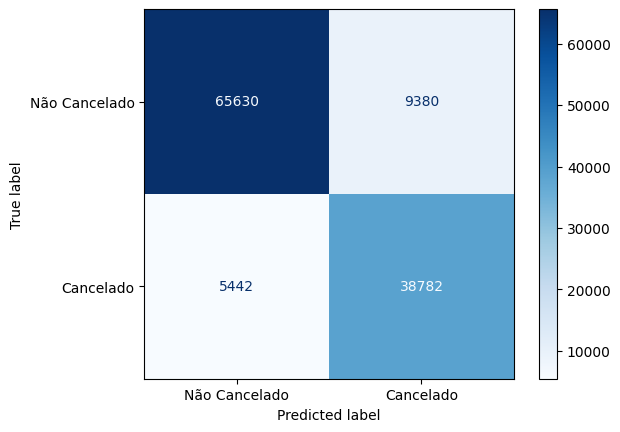

Score: 
               precision    recall  f1-score   support

           0       0.92      0.87      0.90     75010
           1       0.81      0.88      0.84     44224

    accuracy                           0.88    119234
   macro avg       0.86      0.88      0.87    119234
weighted avg       0.88      0.88      0.88    119234



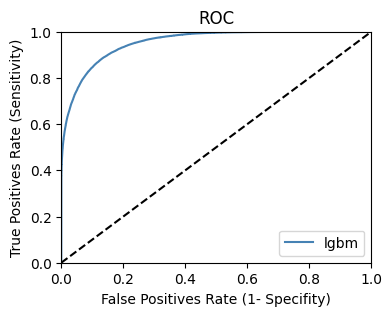

AUC: 0.9541


[LightGBM] [Warning] lambda_l1 is set=1.4719990190180668e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4719990190180668e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.00029953238876537317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029953238876537317
[LightGBM] [Warning] lambda_l1 is set=1.4719990190180668e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4719990190180668e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.00029953238876537317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029953238876537317
[LightGBM] [Warning] lambda_l1 is set=1.4719990190180668e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4719990190180668e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq

,0,1,2,3,4,mean_folds5,std
fit_time,0.4645,0.5119,0.5132,0.5098,0.5638,0.5127,0.0314
score_time,0.0366,0.0379,0.0379,0.0401,0.0374,0.0380,0.0012
test_Accuracy,0.8759,0.8734,0.8784,0.8768,0.8741,0.8757,0.0018
train_Accuracy,0.9042,0.9055,0.9024,0.9041,0.9049,0.9042,0.0010
test_Precision,0.8040,0.8004,0.8104,0.8065,0.8051,0.8053,0.0033
train_Precision,0.8390,0.8406,0.8365,0.8400,0.8390,0.8390,0.0014
test_Recall,0.8798,0.8774,0.8774,0.8786,0.8714,0.8769,0.0029
train_Recall,0.9180,0.9196,0.9157,0.9160,0.9202,0.9179,0.0018
test_F1,0.8402,0.8371,0.8426,0.8410,0.8369,0.8396,0.0022
train_F1,0.8767,0.8783,0.8743,0.8764,0.8777,0.8767,0.0014


In [373]:
model_lgbm_tuned = LGBMClassifier(**lgbm_best_params)
y_prob_lgbm_tuned, y_pred_lgbm_tuned, scores_lgbm_tuned  = CVS(model_lgbm_tuned,X,y,'lgbm')

In [342]:
# lgbm_best_params = {'lambda_l1': 4.426255066752116e-07,
#  'lambda_l2': 9.96556590039312e-08,
#  #'num_leaves': 193,
#  'bagging_freq': 3,
#  'min_child_samples': 8}


# param_range = np.arange(10, 200, 10)


# train_scores = [ ]
# test_scores = [ ]
# for i in param_range:
#     lgbm = LGBMClassifier(**lgbm_best_params,
#         num_leaves = i
# )
#     lgbm.fit(X_train,y_train)
#     train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
#     test_scores.append(f1_score(y_val,lgbm.predict(X_val)))

# plt.subplots(1, figsize=(7,7))
# plt.plot(param_range, train_scores, label="Training", color="black")
# plt.plot(param_range, test_scores, label="Validation", color="dimgrey")

# # plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
# # plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
 
# plt.title("Comparison Train x Validation - LGBM")
# plt.xlabel("Max Depth")
# plt.ylabel("F1 Score")
# plt.tight_layout()
# plt.legend(loc="best")
# plt.show()

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">XGBoost</p></div>

In [380]:
def objective(trial): 
    
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary:logistic']), #binary:logistic    
        'booster': trial.suggest_categorical('booster', ['gbtree','dart']),
        #'metric': trial.suggest_categorical('metric', ['f1']), 
        'eval_metric': trial.suggest_categorical('eval_metric', ['auc']),    
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 150, step=50),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.4, 0.9),     
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,weight]),
        'seed': trial.suggest_categorical('seed', [RANDOM_SEED]),
        #'early_stopping_rounds':100,
        #'verbosity':0,
        #'seed': RANDOM_SEED
        
    }

    model = XGBClassifier(**param_grid)
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    scores = cross_val_score(model, X, y, cv=Kfold, scoring="f1")

    return scores.mean()

In [381]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100); #, show_progress_bar=True

trial = study.best_trial

[I 2023-04-24 14:28:31,064] A new study created in memory with name: no-name-a957cd1f-e808-40a8-9e59-4420ab8cb050
[I 2023-04-24 14:28:36,049] Trial 0 finished with value: 0.7982337503039907 and parameters: {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.03295639876153312, 'n_estimators': 50, 'alpha': 0.06619049430021301, 'lambda': 4.796640641654754e-07, 'min_child_weight': 6, 'colsample_bytree': 0.6111140993567173, 'scale_pos_weight': 1, 'seed': 42}. Best is trial 0 with value: 0.7982337503039907.
[I 2023-04-24 14:28:42,460] Trial 1 finished with value: 0.832560088241264 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.05424492703286242, 'n_estimators': 150, 'alpha': 2.000591345127968e-08, 'lambda': 0.04619124159469232, 'min_child_weight': 3, 'colsample_bytree': 0.41312130109307826, 'scale_pos_weight': 1.696, 'seed': 42}. Best is trial 1 with value:

[I 2023-04-24 14:32:04,237] Trial 18 finished with value: 0.8058762182821239 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 8, 'learning_rate': 0.009268812176410872, 'n_estimators': 150, 'alpha': 1.4069278364478577e-06, 'lambda': 0.0019013817089800576, 'min_child_weight': 6, 'colsample_bytree': 0.7668304877663347, 'scale_pos_weight': 1.696, 'seed': 42}. Best is trial 12 with value: 0.8391855130739944.
[I 2023-04-24 14:32:13,918] Trial 19 finished with value: 0.8356932665228252 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.05971982534824971, 'n_estimators': 150, 'alpha': 7.421075487451623e-05, 'lambda': 0.03687971234054183, 'min_child_weight': 5, 'colsample_bytree': 0.7057469559056435, 'scale_pos_weight': 1.696, 'seed': 42}. Best is trial 12 with value: 0.8391855130739944.
[I 2023-04-24 14:32:20,484] Trial 20 finished with value: 0.8155075479287976 

[I 2023-04-24 14:35:20,388] Trial 36 finished with value: 0.8344364883600311 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.07517550859253873, 'n_estimators': 150, 'alpha': 2.6905788755941484e-08, 'lambda': 0.2219212171675297, 'min_child_weight': 6, 'colsample_bytree': 0.40170158956607455, 'scale_pos_weight': 1.696, 'seed': 42}. Best is trial 26 with value: 0.8395617961420011.
[I 2023-04-24 14:35:28,832] Trial 37 finished with value: 0.8324196906438114 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.05276383175084323, 'n_estimators': 100, 'alpha': 6.826107180460731e-08, 'lambda': 0.0027870269348345316, 'min_child_weight': 4, 'colsample_bytree': 0.6325711447187327, 'scale_pos_weight': 1.696, 'seed': 42}. Best is trial 26 with value: 0.8395617961420011.
[I 2023-04-24 14:36:15,820] Trial 38 finished with value: 0.8084193256022097 a

[I 2023-04-24 14:43:16,807] Trial 54 finished with value: 0.839449835335382 and parameters: {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.08741647752133751, 'n_estimators': 150, 'alpha': 2.48475186723162e-07, 'lambda': 0.006946238301860942, 'min_child_weight': 5, 'colsample_bytree': 0.529733597695654, 'scale_pos_weight': 1.696, 'seed': 42}. Best is trial 48 with value: 0.8404984145941842.
[I 2023-04-24 14:43:53,590] Trial 55 finished with value: 0.836722758512348 and parameters: {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.056637629880780915, 'n_estimators': 150, 'alpha': 3.844152152253679e-06, 'lambda': 0.0061607473441251375, 'min_child_weight': 5, 'colsample_bytree': 0.5333464387181612, 'scale_pos_weight': 1.696, 'seed': 42}. Best is trial 48 with value: 0.8404984145941842.
[I 2023-04-24 14:44:39,565] Trial 56 finished with value: 0.8366329200148961 and par

[I 2023-04-24 14:52:25,438] Trial 72 finished with value: 0.8404678219400105 and parameters: {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.09826423042522095, 'n_estimators': 150, 'alpha': 3.21436928477839e-05, 'lambda': 0.00017127992623133247, 'min_child_weight': 3, 'colsample_bytree': 0.41122847254333683, 'scale_pos_weight': 1.696, 'seed': 42}. Best is trial 67 with value: 0.8412360051533319.
[I 2023-04-24 14:52:53,465] Trial 73 finished with value: 0.8403003949905999 and parameters: {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.09918900830792507, 'n_estimators': 150, 'alpha': 3.676992319051657e-05, 'lambda': 0.00017240778771066042, 'min_child_weight': 3, 'colsample_bytree': 0.4149712061539715, 'scale_pos_weight': 1.696, 'seed': 42}. Best is trial 67 with value: 0.8412360051533319.
[I 2023-04-24 14:53:26,704] Trial 74 finished with value: 0.8403671328878947 a

[I 2023-04-24 15:01:25,302] Trial 90 finished with value: 0.8402545034277309 and parameters: {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.07723032409986981, 'n_estimators': 150, 'alpha': 7.301655310012503e-06, 'lambda': 0.0004981093552494866, 'min_child_weight': 3, 'colsample_bytree': 0.4860676612330663, 'scale_pos_weight': 1.696, 'seed': 42}. Best is trial 67 with value: 0.8412360051533319.
[I 2023-04-24 15:01:52,892] Trial 91 finished with value: 0.8402430631079851 and parameters: {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.09991496349130123, 'n_estimators': 150, 'alpha': 4.921004986974743e-06, 'lambda': 0.00021035707878226822, 'min_child_weight': 3, 'colsample_bytree': 0.4338962116732604, 'scale_pos_weight': 1.696, 'seed': 42}. Best is trial 67 with value: 0.8412360051533319.
[I 2023-04-24 15:02:20,889] Trial 92 finished with value: 0.8395923931667207 an

In [382]:
# Print the result
xgb_best_params = study.best_params
xgb_best_score = study.best_value
print(f"Best score: {xgb_best_score}\n")
print(f"Optimized parameters: {xgb_best_params}\n")

Best score: 0.8412360051533319

Optimized parameters: {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.09965409565501392, 'n_estimators': 150, 'alpha': 1.6823770242253084e-05, 'lambda': 0.0005878323653385145, 'min_child_weight': 3, 'colsample_bytree': 0.4374134158645982, 'scale_pos_weight': 1.696, 'seed': 42}



In [383]:
xgb_best_params

{'objective': 'binary:logistic',
 'booster': 'dart',
 'eval_metric': 'auc',
 'max_depth': 10,
 'learning_rate': 0.09965409565501392,
 'n_estimators': 150,
 'alpha': 1.6823770242253084e-05,
 'lambda': 0.0005878323653385145,
 'min_child_weight': 3,
 'colsample_bytree': 0.4374134158645982,
 'scale_pos_weight': 1.696,
 'seed': 42}

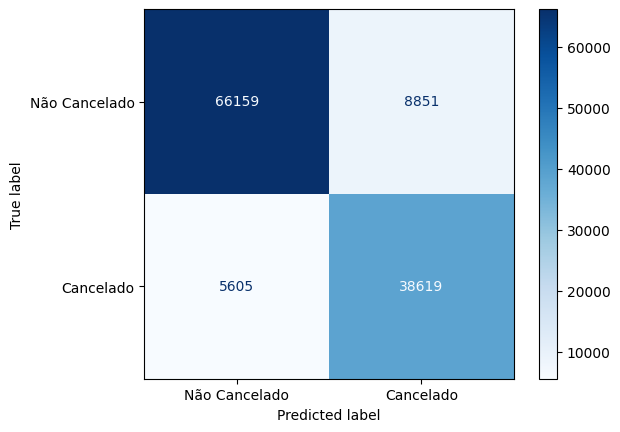

Score: 
               precision    recall  f1-score   support

           0       0.92      0.88      0.90     75010
           1       0.81      0.87      0.84     44224

    accuracy                           0.88    119234
   macro avg       0.87      0.88      0.87    119234
weighted avg       0.88      0.88      0.88    119234



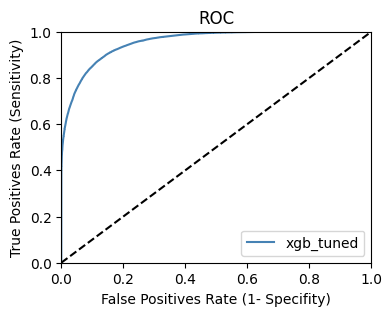

AUC: 0.9553




,0,1,2,3,4,mean_folds5,std
fit_time,12.2211,12.1836,11.7745,12.4493,11.3510,11.9959,0.3890
score_time,0.1962,0.1631,0.1391,0.1576,0.1294,0.1571,0.0230
test_Accuracy,0.8798,0.8778,0.8801,0.8799,0.8762,0.8788,0.0015
train_Accuracy,0.9132,0.9115,0.9115,0.9116,0.9134,0.9122,0.0008
test_Precision,0.8139,0.8100,0.8179,0.8135,0.8124,0.8136,0.0026
train_Precision,0.8527,0.8514,0.8506,0.8509,0.8528,0.8517,0.0009
test_Recall,0.8762,0.8761,0.8705,0.8771,0.8664,0.8733,0.0042
train_Recall,0.9259,0.9224,0.9236,0.9235,0.9262,0.9243,0.0015
test_F1,0.8439,0.8417,0.8434,0.8441,0.8385,0.8423,0.0021
train_F1,0.8878,0.8855,0.8856,0.8857,0.8880,0.8865,0.0011


In [384]:
model_xgb_tuned = XGBClassifier(**xgb_best_params)
y_prob_xgb_tuned, y_pred_xgb_tuned, scores_xgb_tuned  = CVS(model_xgb_tuned,X,y,'xgb_tuned')  

In [59]:
#optuna.visualization.plot_optimization_history(study)

In [60]:
#optuna.visualization.plot_slice(study)

In [61]:
#optuna.visualization.plot_param_importances(study)

In [385]:
xgb_best_params

{'objective': 'binary:logistic',
 'booster': 'dart',
 'eval_metric': 'auc',
 'max_depth': 10,
 'learning_rate': 0.09965409565501392,
 'n_estimators': 150,
 'alpha': 1.6823770242253084e-05,
 'lambda': 0.0005878323653385145,
 'min_child_weight': 3,
 'colsample_bytree': 0.4374134158645982,
 'scale_pos_weight': 1.696,
 'seed': 42}

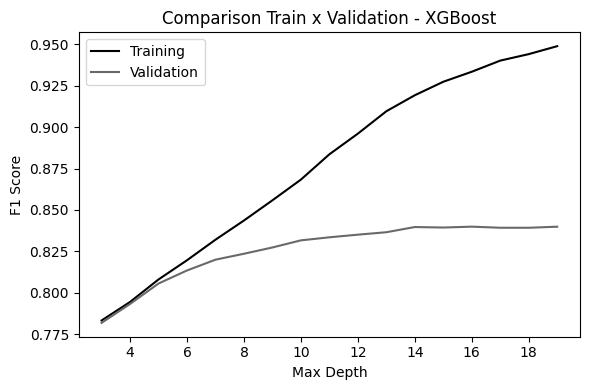

In [129]:
xgb_best_params = {'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'booster': 'gbtree',
 #'max_depth': 10,
 'learning_rate': 0.09971203875947736,
 'n_estimators': 150,
 'alpha': 2.957003467711026e-08,
 'lambda': 4.009830502312534e-07,
 'min_child_weight': 5,
 'colsample_bytree': 0.4584833524080041,
 'scale_pos_weight': 1.696,
 'seed': 42}


param_range = np.arange(3, 20, 1)


train_scores = [ ]
test_scores = [ ]
for i in param_range:
    xgb = XGBClassifier(**xgb_best_params,
        max_depth = i
)
    xgb.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,xgb.predict(X_train)))
    test_scores.append(f1_score(y_val,xgb.predict(X_val)))
    

plt.subplots(1, figsize=(6,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, test_scores, label="Validation", color="dimgrey")

 
plt.title("Comparison Train x Validation - XGBoost")
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()    

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">ANN</p></div>

In [ ]:
def objective_ann(trial):
    input_size = X.shape[1]
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    hidden_size_1 = trial.suggest_int('hidden_size_1', 100, 400, step=50)
    hidden_size_2 = trial.suggest_int('hidden_size_2', 100, 400, step=50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4, step=0.1)

    net = Net(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, dropout_rate=dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    early_stop_epochs = 30
    patience = 0
    best_val_loss = float('inf')
    num_epoch = 300

    for epoch in range(num_epoch):
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
        if epoch % 10 == 0:
            train_score = calculate_f1(y_train, y_pred)
            y_val_pred = net(X_val)
            y_val_pred = torch.squeeze(y_val_pred)
            val_loss = criterion(y_val_pred, y_val)
            val_acc = calculate_f1(y_val, y_val_pred)
            # Verificar se houve melhora no conjunto de validação
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience = 0
            else:
                patience += 1
                if patience >= early_stop_epochs:
                    break
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    return val_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective_ann, n_trials=100)

trial = study.best_trial

In [ ]:
# Print the result
nn_best_params = study.best_params
nn_best_score = study.best_value
print(f"Best score: {nn_best_score}\n")
print(f"Optimized parameters: {nn_best_params}\n")

In [108]:
data_prep

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,adults,meal,is_repeated_guest,previous_cancellations,adr,required_car_parking_spaces,total_of_special_requests,kids,days_stay,agent_encoded,company_encoded,market_segment_Aviation,...,agent_14,agent_28,agent_240,agent_241,agent_250,company_-1,company_0,company_40,company_45,company_67,company_153,company_154,company_174,company_219,company_223,company_281,company_405
0,1,0,342,2015,27,2,2,0,0,0.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,737,2015,27,2,2,0,0,0.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,7,2015,27,1,2,0,0,75.0000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,13,2015,27,1,2,0,0,75.0000,0,0,0,1,-1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,0,14,2015,27,2,2,0,0,98.0000,0,1,0,2,240,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119229,0,0,23,2017,35,2,2,0,0,96.1400,0,0,0,7,-1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
119230,0,0,102,2017,35,3,2,0,0,225.4300,0,2,0,7,9,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
119231,0,0,34,2017,35,2,2,0,0,157.7100,0,4,0,7,9,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
119232,0,0,109,2017,35,2,2,0,0,104.4000,0,0,0,7,-1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Save Model</p></div> 

In [132]:
params_dir = os.path.join(ROOT_DIR, "config", "params")
os.makedirs(params_dir, exist_ok=True) #O parâmetro exist_ok=True faz com que a função não retorne um erro caso a pasta já exista.
now = dt.now().strftime('%Y%m%d%H%M%S')

    
# for dirname, _, filenames in os.walk(f'{ROOT_DIR}\config\params'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))    

In [ ]:
filename_xgb = f'xgb_best_params_{now}_v1.0.json'
params_path = os.path.join(params_dir, filename_xgb)


with open(params_path, 'w') as f:
    json.dump(xgb_best_params, f)

In [133]:
filename_lgbm = f'lgbm_best_params_{now}_v1.0.json'
params_path = os.path.join(params_dir, filename_lgbm)


with open(params_path, 'w') as f:
    json.dump(lgbm_best_params, f)

In [135]:
# NN_name = 'nn_model.pth'
# model_dir = os.path.join(ROOT_DIR, "models")
# os.makedirs(model_dir, exist_ok=True)
# params_path = os.path.join(params_dir, NN_name)

# torch.save(net, NN_name)

In [136]:
# import optuna
# import logging

# logger = logging.getLogger()

# logger.setLevel(logging.INFO)  # Setup the root logger.
# logger.addHandler(logging.FileHandler("foo.log", mode="w"))

# optuna.logging.enable_propagation()  # Propagate logs to the root logger.
# optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

# study = optuna.create_study()

# logger.info("Start optimization.")
# study.optimize(objective, n_trials=10)

# with open("foo.log") as f:
#     assert f.readline().startswith("A new study created")
#     assert f.readline() == "Start optimization.\n"

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Feature Importance</p></div> 

## <div style="color:white;display:fill;border-radius:5px;background-color:#153656;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Enseemble Methods</p></div>

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM Feature Importance</p></div>

[LightGBM] [Warning] lambda_l1 is set=1.4719990190180668e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4719990190180668e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.00029953238876537317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029953238876537317


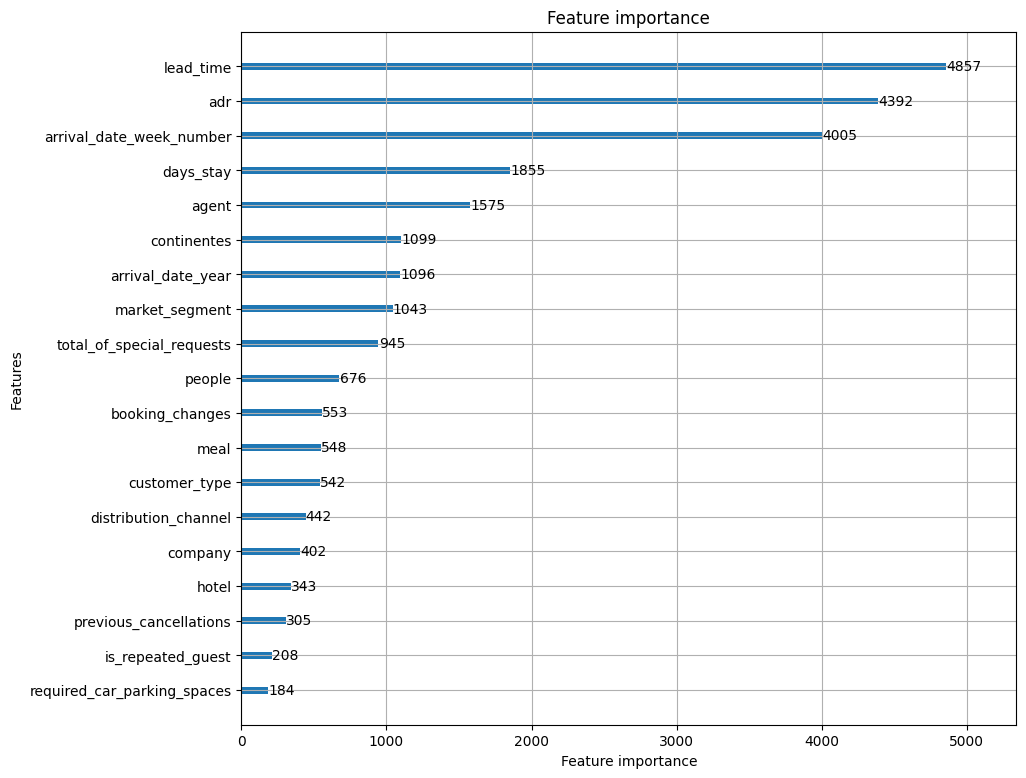

In [386]:
lgbm = LGBMClassifier(**lgbm_best_params)#**lgbm_best_params
lgbm.fit(X, y)
lightgbm.plot_importance(lgbm, figsize=(10, 9));

In [387]:
# fi_lgbm = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': lgbm.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10,6))
# plt.title('Feature Importance - LGBM Classifier')
# sns.barplot(data=fi_lgbm.head(20), x='importance', y='feature', color='SteelBlue');

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">XGBoost Feature Importance</p></div>

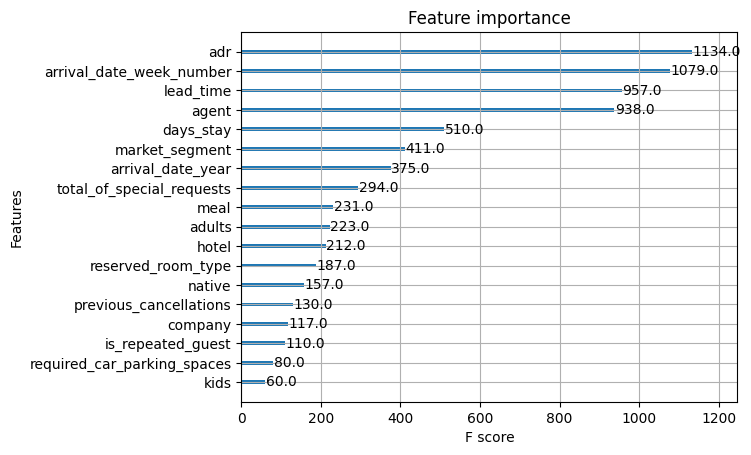

In [142]:
xgb = XGBClassifier(**xgb_best_params)
xgb.fit(X,y)
xgboost.plot_importance(xgb);

#fig1=plt.gcf()
#plt.draw()

In [144]:
# fi_xgb = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': xgb.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10,6))
# plt.title('Feature Importance - XGBoost Classifier')
# sns.barplot(data=fi_xgb.head(15), x='importance', y='feature', color='SteelBlue');
# plt.show()

In [147]:
# lightgbm.plot_tree(lgbm, figsize=(12,12), tree_index=0, dpi=300)

## <div style="color:white;display:fill;border-radius:5px;background-color:#153656;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Filter Methods</p></div>

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Anova</p></div>

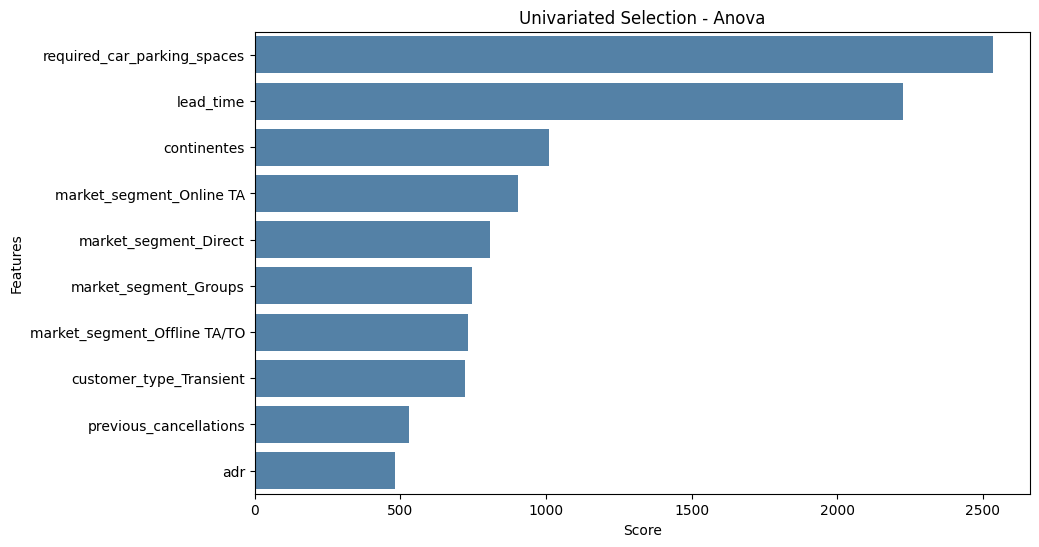

In [141]:
### Apply SelectKBest Algorithm - Anova
anova = SelectKBest(score_func=f_classif, k=10).fit(X,y)
anova_scores=pd.DataFrame(anova.scores_,columns=["Score"])
anova_columns=pd.DataFrame(X.columns)
anova_feature_rank=pd.concat([anova_columns,anova_scores],axis=1)
anova_feature_rank.columns=['Features','Score']
anova_feature_rank=anova_feature_rank.nlargest(10,'Score')

plt.figure(figsize=(10,6))
plt.title('Univariated Selection - Anova')
sns.barplot(data=anova_feature_rank, x='Score', y='Features', color='SteelBlue');
plt.show()

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Correlation Coeficient</p></div>

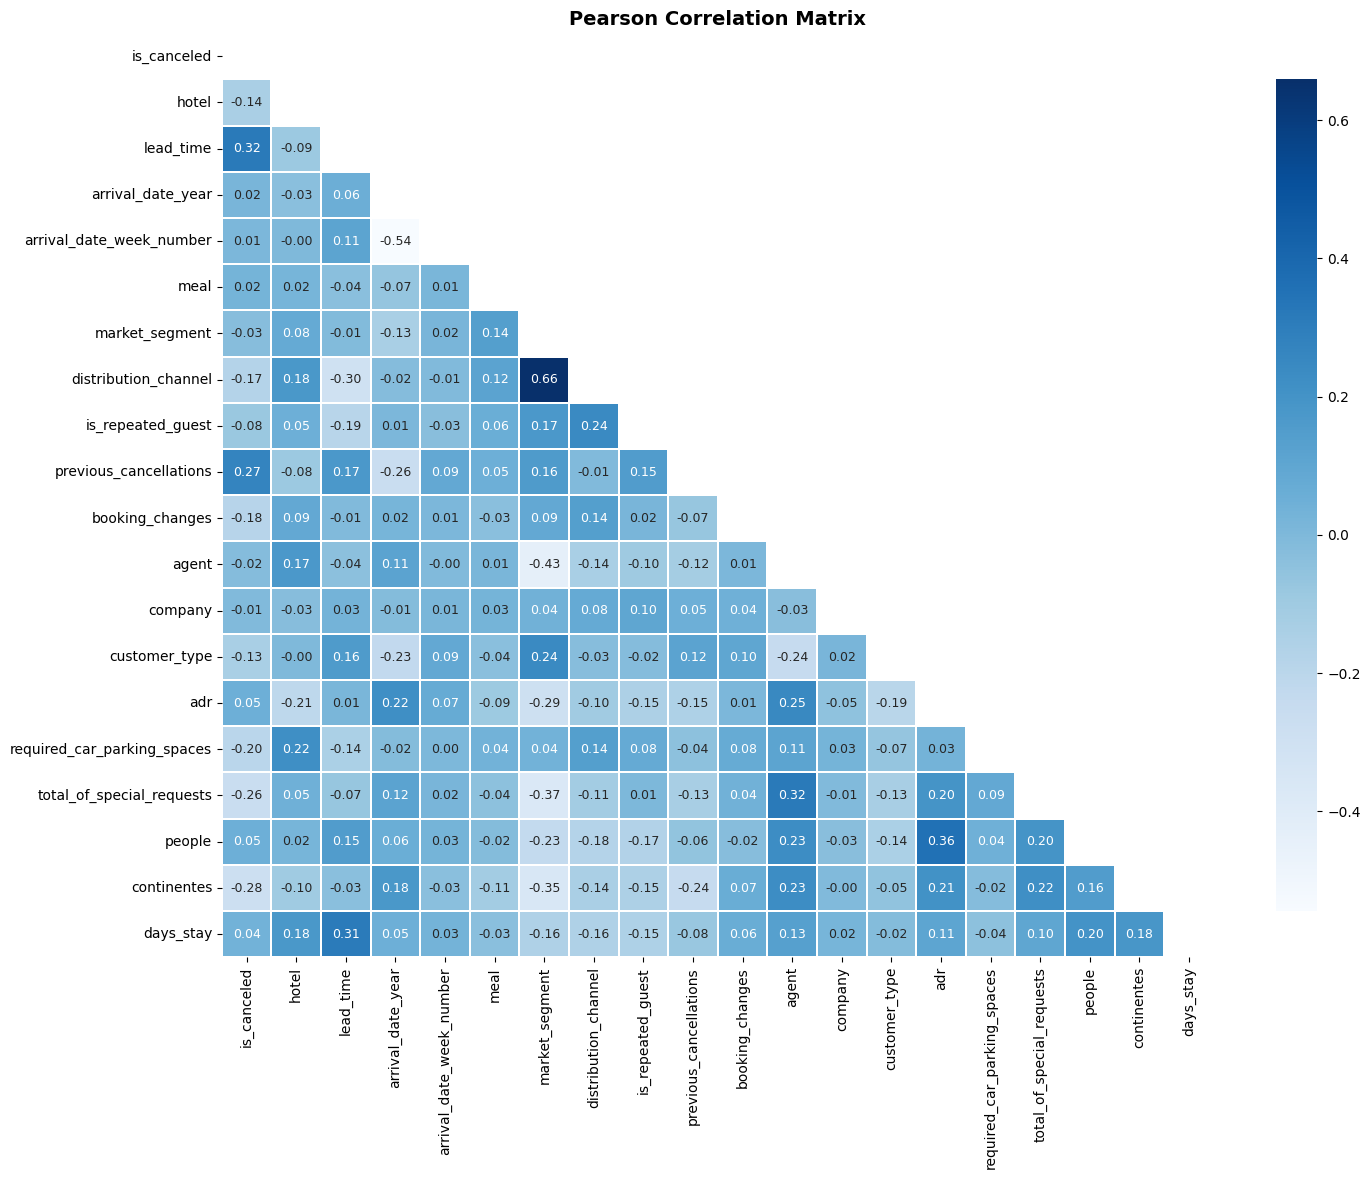

In [388]:
aux = pd.concat([data_prep[target],data_prep[selected_features]], axis=1)

mask = np.zeros_like(aux.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))

plt.title('Pearson Correlation Matrix',fontsize=14, fontweight='bold')

sns.heatmap(aux.corr(method='spearman'), linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Shapley</p></div>

In [389]:
shap.initjs()

In [390]:
model = LGBMClassifier(**lgbm_best_params)#**lgbm_best_params
model.fit(X, y)


explainer = shap.Explainer(model, X)
shap_values = explainer(X)

100%|===================| 119122/119234 [12:50<00:00]        

In [453]:
# train = pd.concat([X,y], axis=1)
# train.loc[train.is_canceled ==1].tail()

In [454]:
#300 Not Canceled, Resort Hotel, Parking Required - Acertou
#96 Canceled, Native, Special Request - Acertou

#138,630 Canceled,
#630 Canceled
#120 Not Canceled, Resort Hotel, Native
#151 Not Canceled, Resort Hotel, No Native

#96655 Not Canceled, City Hotel, No Native
#95241 Not Canceled City Hotel, No Native
idx = 138

In [455]:
data.groupby('customer_type')['is_canceled'].mean()

customer_type
Contract          0.3099
Group             0.1026
Transient         0.4080
Transient-Party   0.2546
Name: is_canceled, dtype: float64

In [456]:
data.groupby(['arrival_date_year','hotel'])['is_canceled'].mean()

arrival_date_year  hotel       
2015               City Hotel     0.4396
                   Resort Hotel   0.2573
2016               City Hotel     0.4047
                   Resort Hotel   0.2655
2017               City Hotel     0.4258
                   Resort Hotel   0.3078
Name: is_canceled, dtype: float64

In [457]:
data.iloc[idx,:]

hotel                                    Resort Hotel
is_canceled                                         1
lead_time                                           5
arrival_date_year                                2015
arrival_date_month                               July
arrival_date_week_number                           28
arrival_date_day_of_month                           5
stays_in_weekend_nights                             1
stays_in_week_nights                                0
adults                                              2
children                                            0
babies                                              0
meal                                               BB
country                                           PRT
market_segment                              Online TA
distribution_channel                            TA/TO
is_repeated_guest                                   0
previous_cancellations                              0
previous_bookings_not_cancel

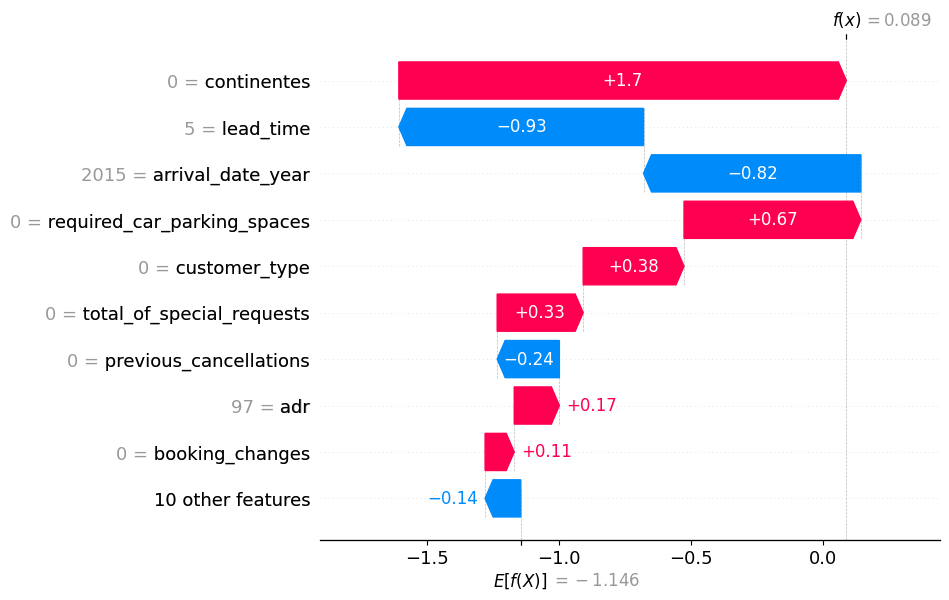

In [458]:
shap.plots.waterfall(shap_values[idx,:])

In [423]:
# visualize the first prediction's explanation with a force plot
#shap.plots.force(shap_values[idx,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


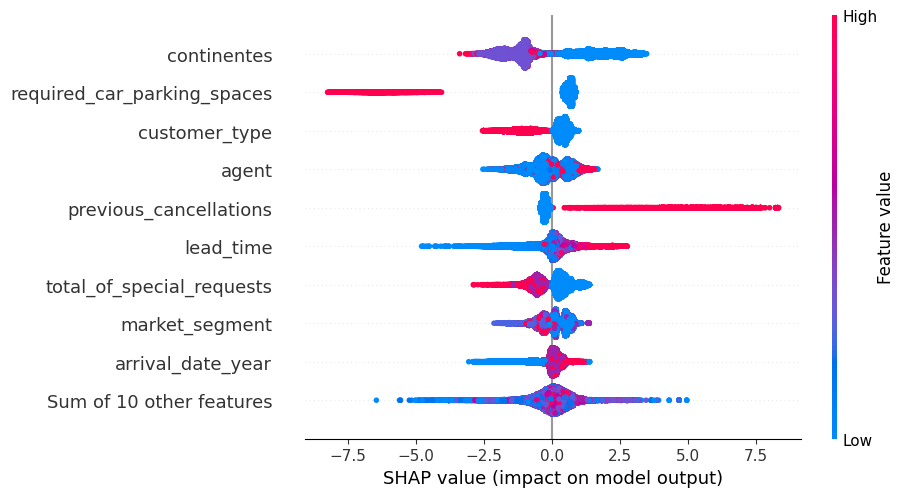

In [396]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

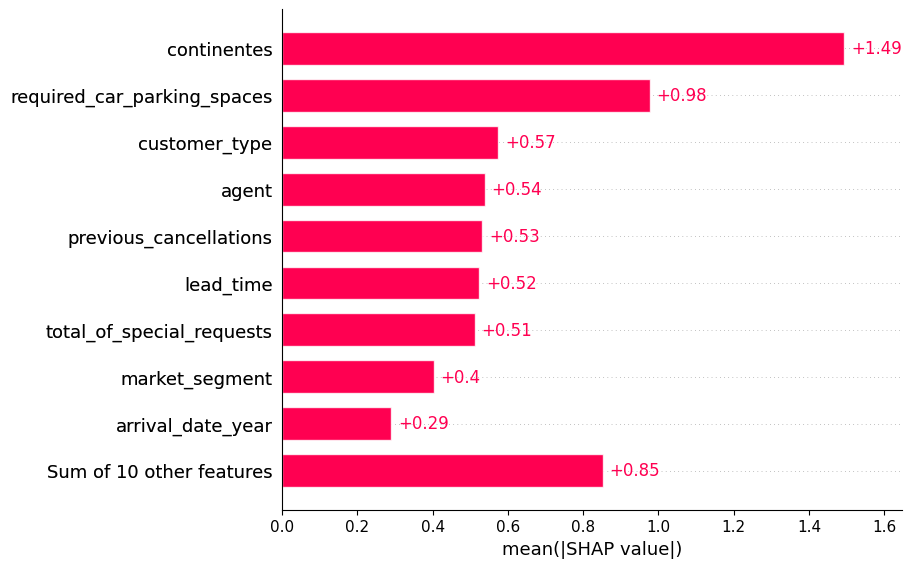

In [429]:
shap.plots.bar(shap_values)

In [434]:
shap.plots.force(shap_values[0:100])

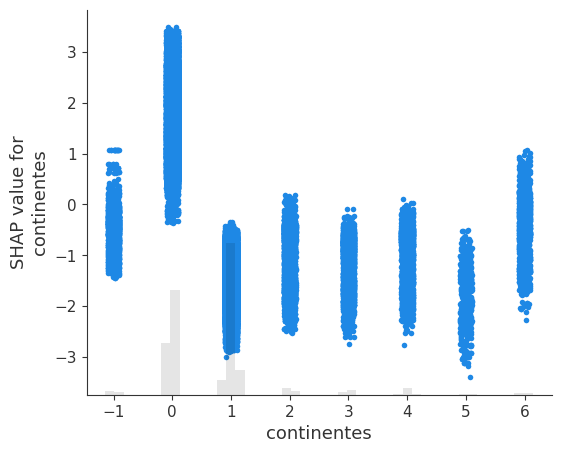

In [436]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"continentes"])#, color=shap_values

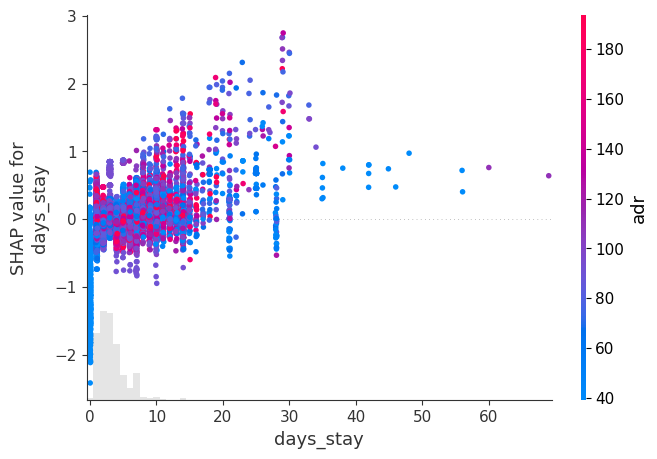

In [452]:
shap.plots.scatter(shap_values[:,"days_stay"],
                   color=shap_values[:,"adr"])

In [448]:
data.customer_type.unique(), data.customer_type.value_counts()

(array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object),
 Transient          89496
 Transient-Party    25091
 Contract            4072
 Group                575
 Name: customer_type, dtype: int64)

In [450]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'people', 'kids',
       'days_stay', 'country_name', 'continentes'],
      dtype='object')